In [1]:
import json
import os
import warnings
from pathlib import Path
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import rearrange, repeat
from ipywidgets import interact
from jax import config, device_count, random
from jax.scipy.optimize import minimize
from numpyencoder import NumpyEncoder
from scipy import constants
from stamox.sample import bootstrap

from jackpot.algorithms import AlgorithmChoice
from jackpot.algorithms.base import Algorithm
from jackpot.config import Config, JaxPlatform
from jackpot.fitting import SaturatingExponential
from jackpot.models.base import Model
from jackpot.models.ising import IsingModel
from jackpot.modules import AutocorrelationData
from jackpot.primitives.autocorrelate import acf
from jackpot.primitives.utils import beta_to_temp
from jackpot.profile import Stopwatch
from jackpot.state import Measurement, State
from jackpot.typing import RNGKey
from jackpot.utils.map import filter_map
from jackpot.utils.pbar import make_scan
from jackpot.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

In [2]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [3]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False
DO_AUTOCORRELATION: bool = False
DO_MEASURE: bool = True
PLOT_STATES: bool = False
CHECK_THERMALISED: bool = True

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 32
TOTAL_SAMPLES: int = 384
N_SAMPLES_VECTORISE: int = 2
LOOP_N_TEMPS_Y: bool = False


# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: AlgorithmChoice = AlgorithmChoice.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.80
TEMP_MAX: float = 1.90
N_TEMPS: int = 96

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# autocorrelation
AUTOCORRELATION_STEPS: int = 1000
AUTOCORRELATION_SWEEPS_PER_STEP: int = 2

# measure
MEASURE_EQUILIBRIUM_STEPS: int = 100
MEASURE_EQUILIBRIUM_NUM: int = 10
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP: int = 5

In [4]:
# Parameters
PAPERMILL_INPUT_PATH = "workbench.ipynb"
PAPERMILL_OUTPUT_PATH = "experiments/autocorrelation/N32_swendsen_wang/experiment.ipynb"
PAPERMILL = True
RNG_SEED = 1
JAX_PLATFORM = "cpu"
ALGORITHM = "swendsen_wang"
DIMENSIONS = 2
SPIN = 0.5
TOTAL_SAMPLES = 256
N_TEMPS = 64
N_SAMPLES_VECTORISE = 4
THERMALISE_STEPS = 100
THERMALISE_SWEEPS_PER_STEP = 100
TEMP_MIN = 0.9
TEMP_MAX = 1.4
DO_AUTOCORRELATION = True
DO_MEASURE = False
PLOT_STATES = False
SIZE = 32
AUTOCORRELATION_SWEEPS_PER_STEP = 1

In [5]:
if not PAPERMILL:
    RNG_SEED = 1
    JAX_PLATFORM = "cpu"
    ALGORITHM = "swendsen_wang"
    DIMENSIONS = 2
    SPIN = 0.5
    TOTAL_SAMPLES = 128
    N_TEMPS = 64
    N_SAMPLES_VECTORISE = 2
    THERMALISE_STEPS = 100
    THERMALISE_SWEEPS_PER_STEP = 50
    TEMP_MIN = 1.00
    # TEMP_MAX = 1.25
    TEMP_MAX = 1.4
    DO_AUTOCORRELATION = True
    DO_MEASURE = True
    SIZE = 32

In [6]:
# Post init
if PAPERMILL:
    from tqdm.std import tqdm
else:
    from tqdm.notebook import tqdm

if PAPERMILL_OUTPUT_PATH:
    SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent.resolve()
else:
    SAVE_PATH = (Path() / "experiments" / "last").resolve()
to_save: dict[str, Any] = {}

print(f"{SAVE_PATH=}")

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "DO_AUTOCORRELATION",
    "DO_MEASURE",
    "PLOT_STATES",
    "CHECK_THERMALISED",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "N_SAMPLES_VECTORISE",
    "LOOP_N_TEMPS_Y",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
    "AUTOCORRELATION_STEPS",
    "AUTOCORRELATION_SWEEPS_PER_STEP",
    "MEASURE_EQUILIBRIUM_STEPS",
    "MEASURE_EQUILIBRIUM_NUM",
    "MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

with open(SAVE_PATH / "config.json", "w") as f:
    f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        from jax.experimental.compilation_cache import compilation_cache

        compilation_cache.initialize_cache("/tmp/xla_comp_cache")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

SAVE_PATH=PosixPath('/home/jeppe/JaxIsingModel/experiments/autocorrelation/N32_swendsen_wang')


In [7]:
# Init

DEVICE_COUNT = device_count()
to_save["DEVICE_COUNT"] = DEVICE_COUNT
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
to_save["rng_seed"] = rng_seed
k = EasyKey(rng_seed)
rng_key = k.new

MODEL_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    # "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

if c.n_temps < DEVICE_COUNT:
    warnings.warn(
        f"Should have at least {DEVICE_COUNT} temperatures for maximum throughput"
    )
N_TEMPS_X = DEVICE_COUNT if DEVICE_COUNT < c.n_temps else c.n_temps
N_TEMPS_Y = c.n_temps // N_TEMPS_X
to_save["N_TEMPS_X"] = N_TEMPS_X
to_save["N_TEMPS_Y"] = N_TEMPS_Y

if not N_TEMPS_X * N_TEMPS_Y == c.n_temps:
    raise ValueError(f"Temperatures should be a multiple of {DEVICE_COUNT}")

N_SAMPLES_PER_TEMP = c.total_samples // (N_TEMPS_X * N_TEMPS_Y)
N_SAMPLES_LOOP = N_SAMPLES_PER_TEMP // c.n_samples_vectorise
to_save["N_SAMPLES_PER_TEMP"] = N_SAMPLES_PER_TEMP
to_save["N_SAMPLES_LOOP"] = N_SAMPLES_LOOP

VECTORISATION_SHAPE = (N_SAMPLES_LOOP, N_TEMPS_X, N_TEMPS_Y, c.n_samples_vectorise)

print(f"Temperatures: {c.n_temps:_}")
print(f"{c.n_temps=}")
print(f"{N_TEMPS_X=}")
print(f"{N_TEMPS_Y=}")
print(f"{N_SAMPLES_PER_TEMP=}")
print(f"--{c.n_samples_vectorise=}")
print(f"--{N_SAMPLES_LOOP=}")

if not N_SAMPLES_LOOP * c.n_samples_vectorise == N_SAMPLES_PER_TEMP:
    raise ValueError(
        "Failed to factorise in a good way. " f"Factors: {VECTORISATION_SHAPE}"
    )
to_save["VECTORISATION_SHAPE"] = VECTORISATION_SHAPE

VECTORISED_COUNT = np.prod(VECTORISATION_SHAPE)
to_save["VECTORISED_COUNT"] = VECTORISED_COUNT
print(f"Vectorised count: {VECTORISED_COUNT:_}")

if not VECTORISED_COUNT == c.total_samples:
    raise ValueError(
        f"Got bad vectorised count: {VECTORISED_COUNT=} != {c.total_samples=}"
    )

TOTAL_SWEEPS = VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps
to_save["TOTAL_SWEEPS"] = TOTAL_SWEEPS
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

temperatures = np.linspace(c.temp_min, c.temp_max, c.n_temps)
betas = 1.0 / temperatures

match c.algorithm:
    case AlgorithmChoice.WOLFF | AlgorithmChoice.SWENDSEN_WANG:
        algorithm = c.algorithm.resolve()(
            probabilistic_cluster_accept=c.probabilistic_cluster_accept
        )
    case _:
        algorithm = c.algorithm.resolve()()


def transforms(in_axes, out_axes=0):
    def inner(fun):
        # SAMPLES_VECTORISE
        fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_Y
        if c.loop_n_temps_y:
            fun = filter_map(fun)
        else:
            fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_X
        fun = eqx.filter_pmap(fun, in_axes=in_axes, out_axes=out_axes)

        # SAMPLES_LOOP
        fun = filter_map(fun)

        fun = eqx.filter_jit(fun)

        return fun

    return inner


def calculate_known_total(steps: int) -> int:
    total = steps
    total *= N_SAMPLES_LOOP
    total *= N_TEMPS_X

    if c.loop_n_temps_y:
        total *= N_TEMPS_Y

    return total

Temperatures: 64
c.n_temps=64
N_TEMPS_X=64
N_TEMPS_Y=1
N_SAMPLES_PER_TEMP=4
--c.n_samples_vectorise=4
--N_SAMPLES_LOOP=1
Vectorised count: 256
Total sweeps: 2_560_000


/tmp/ipykernel_849156/363494175.py:21: UserWarning: Should have at least 96 temperatures for maximum throughput
  warnings.warn(


In [8]:
# Single state
if not PAPERMILL:
    model = IsingModel.new(spin=c.spin, **MODEL_BASE_PARAMS)
    state = State.new_uniform_random(
        rng_key=k.new,
        dimensions=c.dimensions,
        size=c.size,
        beta=1.0,
        model=model,
        algorithm=algorithm,
        id_=0,
    )

    initial_state = state

    state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
    measured = state.measure()

    state.calculate_energy()
    state.calculate_magnetisation_density()

# Thermalisation

In [9]:
@transforms(in_axes=(0, None, None, 0, 0, None, None, None, None, None))
def make_and_thermalise_states(
    rng_key: RNGKey,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    model: Model,
    algorithm: Algorithm,
    num_prints: int = 10,
) -> tuple[State, Measurement]:
    """
    Constructs states and thermalises them, returning measurements along the
    way in addition to the thermalised states.

    Arguments:
        rng_key: Source of randomness,
        dimensions: Dimensionality of the system,
        size: Size of each lattice dimension,
        beta: The inverse temperature,
        id_: An ID of the state,
        steps: Number of steps in which to thermalise the state,
        sweeps_per_step: How many times to perform a algorithm sweep per
            thermalisation step,
        model: Instance of the model to use,
        algorithm: An instance of the algorithm to use,
        num_prints: Number of times to update the progress bar (approximately),
    """
    rng_key, state_key = random.split(key=rng_key, num=2)

    state = State.new_minimal(
        rng_key=state_key,
        dimensions=dimensions,
        size=size,
        beta=beta,
        model=model,
        algorithm=algorithm,
        id_=id_,
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


_betas = rearrange(betas, "(x y) -> x y", x=N_TEMPS_X, y=N_TEMPS_Y)
_betas = repeat(
    _betas,
    "x y -> s_loop x y s_vec",
    s_vec=c.n_samples_vectorise,
    s_loop=N_SAMPLES_LOOP,
)
shape = _betas.shape
print(f"{shape=}")

ids = np.arange(np.prod(shape)).reshape(shape)

# Make state
model = IsingModel.new(
    spin=c.spin,
    **MODEL_BASE_PARAMS,
)

# rng_key: RNGKey
# spin: floatj
# dimensions: int
# size: int
# beta: float
# id_: int
# steps: int
# sweeps_per_step: int
# kwargs: dict[str, Any]
# num_prints: int = 10
state_keys = k.shaped(shape)
thermalise_num_prints = 10

thermalise_compile_timer = Stopwatch.start()
make_and_thermalise_states_compiled = make_and_thermalise_states.lower(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
).compile()
thermalise_compile_time = thermalise_compile_timer.time()
to_save["thermalise_compile_time"] = thermalise_compile_time
print(f"Compiled thermalisation program in: {thermalise_compile_time} sec.")

thermalise_run_timer = Stopwatch.start()
states, evolve_measurements = make_and_thermalise_states_compiled(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
)
states.block_until_ready()
thermalise_run_time = thermalise_run_timer.time()
to_save["thermalise_run_time"] = thermalise_run_time
print(f"Ran thermalisation program in: {thermalise_run_time} sec.")

eqx.tree_serialise_leaves(SAVE_PATH / "states.eqx", states)

shape=(1, 64, 1, 4)


/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function make_and_thermalise_states includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


Compiled thermalisation program in: 5.253547430038452 sec.


  0%|                                                                                      | 0/6400 [00:00<?, ?it/s]

  1%|▊                                                                          | 74/6400 [01:40<2:22:48,  1.35s/it]

  1%|▉                                                                          | 84/6400 [01:43<2:04:35,  1.18s/it]

  1%|█                                                                          | 94/6400 [01:44<1:44:05,  1.01it/s]

  2%|█▏                                                                        | 104/6400 [01:52<1:38:31,  1.06it/s]

  2%|█▎                                                                        | 114/6400 [01:55<1:23:08,  1.26it/s]

  2%|█▍                                                                        | 124/6400 [01:58<1:10:06,  1.49it/s]

  2%|█▌                                                                        | 134/6400 [02:01<1:00:11,  1.74it/s]

  2%|█▋                                                                        | 144/6400 [02:10<1:10:37,  1.48it/s]

  2%|█▊                                                                          | 154/6400 [02:12<53:58,  1.93it/s]

  3%|█▉                                                                          | 164/6400 [02:15<47:32,  2.19it/s]

  3%|██                                                                        | 174/6400 [02:25<1:04:31,  1.61it/s]

  3%|██▏                                                                       | 184/6400 [02:31<1:04:50,  1.60it/s]

  3%|██▏                                                                       | 194/6400 [02:39<1:09:39,  1.48it/s]

  3%|██▎                                                                       | 204/6400 [02:47<1:13:02,  1.41it/s]

  3%|██▍                                                                       | 214/6400 [02:54<1:14:11,  1.39it/s]

  4%|██▌                                                                       | 224/6400 [03:06<1:26:33,  1.19it/s]

  4%|██▋                                                                       | 234/6400 [03:08<1:08:36,  1.50it/s]

  4%|██▊                                                                       | 244/6400 [03:18<1:19:01,  1.30it/s]

  4%|██▉                                                                       | 254/6400 [03:21<1:01:45,  1.66it/s]

  4%|███▏                                                                        | 264/6400 [03:25<55:42,  1.84it/s]

  4%|███▎                                                                        | 274/6400 [03:31<58:14,  1.75it/s]

  4%|███▎                                                                        | 284/6400 [03:32<45:20,  2.25it/s]

  5%|███▍                                                                        | 294/6400 [03:42<59:40,  1.71it/s]

  5%|███▌                                                                        | 304/6400 [03:43<47:22,  2.14it/s]

  5%|███▋                                                                        | 314/6400 [03:51<54:47,  1.85it/s]

  5%|███▊                                                                        | 324/6400 [03:57<57:31,  1.76it/s]

  5%|████                                                                        | 344/6400 [04:02<42:44,  2.36it/s]

  6%|████▏                                                                       | 354/6400 [04:07<43:53,  2.30it/s]

  6%|████▏                                                                     | 364/6400 [04:18<1:02:11,  1.62it/s]

  6%|████▍                                                                       | 374/6400 [04:20<49:39,  2.02it/s]

  6%|████▌                                                                       | 384/6400 [04:23<44:47,  2.24it/s]

  6%|████▋                                                                       | 394/6400 [04:31<56:13,  1.78it/s]

  6%|████▋                                                                     | 404/6400 [04:46<1:20:46,  1.24it/s]

  6%|████▊                                                                     | 414/6400 [04:48<1:03:09,  1.58it/s]

  7%|████▉                                                                     | 424/6400 [04:57<1:12:38,  1.37it/s]

  7%|█████                                                                     | 434/6400 [05:01<1:02:00,  1.60it/s]

  7%|█████▍                                                                      | 454/6400 [05:07<46:19,  2.14it/s]

  7%|█████▌                                                                      | 464/6400 [05:14<51:54,  1.91it/s]

  7%|█████▋                                                                      | 474/6400 [05:20<55:07,  1.79it/s]

  8%|█████▋                                                                      | 484/6400 [05:26<55:37,  1.77it/s]

  8%|█████▊                                                                      | 494/6400 [05:31<53:04,  1.85it/s]

  8%|█████▉                                                                      | 504/6400 [05:32<41:38,  2.36it/s]

  8%|██████                                                                      | 514/6400 [05:34<35:53,  2.73it/s]

  8%|██████▏                                                                     | 524/6400 [05:35<26:36,  3.68it/s]

  8%|██████▎                                                                     | 534/6400 [05:36<21:52,  4.47it/s]

  8%|██████▍                                                                     | 544/6400 [05:36<16:01,  6.09it/s]

  9%|██████▌                                                                     | 554/6400 [05:38<15:36,  6.24it/s]

  9%|██████▋                                                                     | 564/6400 [05:42<23:42,  4.10it/s]

  9%|██████▉                                                                     | 584/6400 [05:46<20:49,  4.66it/s]

  9%|███████                                                                     | 594/6400 [05:48<21:12,  4.56it/s]

  9%|███████▏                                                                    | 604/6400 [05:49<18:52,  5.12it/s]

 10%|███████▎                                                                    | 614/6400 [05:51<17:31,  5.50it/s]

 10%|███████▍                                                                    | 624/6400 [05:52<15:21,  6.27it/s]

 10%|███████▌                                                                    | 634/6400 [05:54<16:02,  5.99it/s]

 10%|███████▋                                                                    | 644/6400 [05:56<19:38,  4.89it/s]

 10%|███████▊                                                                    | 654/6400 [05:58<17:08,  5.59it/s]

 10%|███████▉                                                                    | 664/6400 [05:59<14:51,  6.44it/s]

 11%|████████                                                                    | 674/6400 [05:59<11:28,  8.32it/s]

 11%|████████                                                                    | 684/6400 [06:01<13:07,  7.25it/s]

 11%|████████▏                                                                   | 694/6400 [06:01<10:46,  8.82it/s]

 11%|████████▎                                                                   | 704/6400 [06:06<21:33,  4.40it/s]

 11%|████████▍                                                                   | 714/6400 [06:08<18:54,  5.01it/s]

 11%|████████▌                                                                   | 724/6400 [06:11<21:57,  4.31it/s]

 11%|████████▋                                                                   | 734/6400 [06:12<19:46,  4.78it/s]

 12%|████████▊                                                                   | 744/6400 [06:14<19:25,  4.85it/s]

 12%|████████▉                                                                   | 754/6400 [06:15<16:01,  5.87it/s]

 12%|█████████                                                                   | 764/6400 [06:20<25:29,  3.68it/s]

 12%|█████████▏                                                                  | 774/6400 [06:27<38:04,  2.46it/s]

 12%|█████████▎                                                                  | 784/6400 [06:28<29:31,  3.17it/s]

 12%|█████████▍                                                                  | 794/6400 [06:30<23:48,  3.92it/s]

 13%|█████████▌                                                                  | 804/6400 [06:30<17:40,  5.28it/s]

 13%|█████████▋                                                                  | 814/6400 [06:33<22:06,  4.21it/s]

 13%|█████████▊                                                                  | 824/6400 [06:38<27:30,  3.38it/s]

 13%|█████████▉                                                                  | 834/6400 [06:46<41:40,  2.23it/s]

 13%|██████████▏                                                                 | 854/6400 [06:47<25:12,  3.67it/s]

 14%|██████████▎                                                                 | 864/6400 [06:48<21:19,  4.33it/s]

 14%|██████████▍                                                                 | 874/6400 [06:54<29:01,  3.17it/s]

 14%|██████████▍                                                                 | 884/6400 [06:54<21:58,  4.18it/s]

 14%|██████████▌                                                                 | 894/6400 [06:59<29:13,  3.14it/s]

 14%|██████████▋                                                                 | 904/6400 [07:00<21:23,  4.28it/s]

 14%|██████████▊                                                                 | 914/6400 [07:01<17:43,  5.16it/s]

 14%|██████████▉                                                                 | 924/6400 [07:03<18:22,  4.97it/s]

 15%|███████████                                                                 | 934/6400 [07:15<45:59,  1.98it/s]

 15%|███████████▏                                                                | 944/6400 [07:16<34:24,  2.64it/s]

 15%|███████████▎                                                                | 954/6400 [07:16<25:07,  3.61it/s]

 15%|███████████▍                                                                | 964/6400 [07:20<28:02,  3.23it/s]

 15%|███████████▌                                                                | 974/6400 [07:23<28:25,  3.18it/s]

 15%|███████████▋                                                                | 984/6400 [07:29<34:13,  2.64it/s]

 16%|███████████▊                                                                | 994/6400 [07:33<35:49,  2.51it/s]

 16%|███████████▊                                                               | 1004/6400 [07:35<29:45,  3.02it/s]

 16%|███████████▉                                                               | 1014/6400 [07:44<46:24,  1.93it/s]

 16%|████████████                                                               | 1024/6400 [07:47<39:14,  2.28it/s]

 16%|████████████                                                               | 1034/6400 [07:52<41:57,  2.13it/s]

 16%|████████████▏                                                              | 1044/6400 [07:53<31:13,  2.86it/s]

 16%|████████████▎                                                              | 1054/6400 [07:57<31:44,  2.81it/s]

 17%|████████████▍                                                              | 1064/6400 [08:01<32:55,  2.70it/s]

 17%|████████████▌                                                              | 1074/6400 [08:05<35:12,  2.52it/s]

 17%|████████████▋                                                              | 1084/6400 [08:09<35:49,  2.47it/s]

 17%|████████████▊                                                              | 1094/6400 [08:11<29:29,  3.00it/s]

 17%|████████████▉                                                              | 1104/6400 [08:12<22:44,  3.88it/s]

 17%|█████████████                                                              | 1114/6400 [08:12<16:57,  5.20it/s]

 18%|█████████████▏                                                             | 1124/6400 [08:14<16:08,  5.45it/s]

 18%|█████████████▎                                                             | 1134/6400 [08:19<23:31,  3.73it/s]

 18%|█████████████▍                                                             | 1144/6400 [08:29<44:44,  1.96it/s]

 18%|█████████████▌                                                             | 1154/6400 [08:33<41:42,  2.10it/s]

 18%|█████████████▋                                                             | 1164/6400 [08:37<37:14,  2.34it/s]

 18%|█████████████▊                                                             | 1174/6400 [08:40<36:15,  2.40it/s]

 18%|█████████████▉                                                             | 1184/6400 [08:45<36:13,  2.40it/s]

 19%|█████████████▉                                                             | 1194/6400 [08:46<27:38,  3.14it/s]

 19%|██████████████                                                             | 1204/6400 [08:51<33:42,  2.57it/s]

 19%|█████████████▊                                                           | 1214/6400 [09:07<1:06:11,  1.31it/s]

 19%|██████████████▎                                                            | 1224/6400 [09:08<48:11,  1.79it/s]

 19%|██████████████▍                                                            | 1234/6400 [09:15<50:25,  1.71it/s]

 19%|██████████████▏                                                          | 1244/6400 [09:27<1:06:41,  1.29it/s]

 20%|██████████████▎                                                          | 1254/6400 [09:37<1:12:16,  1.19it/s]

 20%|██████████████▍                                                          | 1264/6400 [09:44<1:07:36,  1.27it/s]

 20%|██████████████▉                                                            | 1274/6400 [09:44<48:54,  1.75it/s]

 20%|███████████████                                                            | 1284/6400 [09:49<45:56,  1.86it/s]

 20%|███████████████▏                                                           | 1294/6400 [09:52<40:34,  2.10it/s]

 20%|██████████████▊                                                          | 1304/6400 [10:07<1:06:10,  1.28it/s]

 21%|███████████████▍                                                           | 1314/6400 [10:07<47:23,  1.79it/s]

 21%|███████████████▌                                                           | 1324/6400 [10:09<36:03,  2.35it/s]

 21%|███████████████▋                                                           | 1334/6400 [10:15<40:10,  2.10it/s]

 21%|███████████████▊                                                           | 1344/6400 [10:23<49:39,  1.70it/s]

 21%|███████████████▊                                                           | 1354/6400 [10:31<54:04,  1.56it/s]

 21%|███████████████▉                                                           | 1364/6400 [10:35<47:54,  1.75it/s]

 21%|████████████████                                                           | 1374/6400 [10:36<36:43,  2.28it/s]

 22%|████████████████▏                                                          | 1384/6400 [10:42<41:30,  2.01it/s]

 22%|████████████████▎                                                          | 1394/6400 [10:44<33:36,  2.48it/s]

 22%|████████████████▍                                                          | 1404/6400 [10:57<54:18,  1.53it/s]

 22%|████████████████▌                                                          | 1414/6400 [11:05<59:52,  1.39it/s]

 22%|████████████████▋                                                          | 1424/6400 [11:10<53:21,  1.55it/s]

 22%|████████████████▊                                                          | 1434/6400 [11:10<37:35,  2.20it/s]

 23%|████████████████▉                                                          | 1444/6400 [11:13<34:19,  2.41it/s]

 23%|█████████████████                                                          | 1454/6400 [11:16<29:34,  2.79it/s]

 23%|█████████████████▏                                                         | 1464/6400 [11:17<23:05,  3.56it/s]

 23%|█████████████████▎                                                         | 1474/6400 [11:18<18:25,  4.46it/s]

 23%|█████████████████▍                                                         | 1484/6400 [11:23<26:45,  3.06it/s]

 23%|█████████████████▌                                                         | 1494/6400 [11:24<21:15,  3.85it/s]

 24%|█████████████████▋                                                         | 1504/6400 [11:26<18:27,  4.42it/s]

 24%|█████████████████▋                                                         | 1514/6400 [11:27<16:35,  4.91it/s]

 24%|█████████████████▊                                                         | 1524/6400 [11:33<25:38,  3.17it/s]

 24%|█████████████████▉                                                         | 1534/6400 [11:34<21:02,  3.86it/s]

 24%|██████████████████                                                         | 1544/6400 [11:36<18:45,  4.31it/s]

 24%|██████████████████▏                                                        | 1554/6400 [11:40<21:43,  3.72it/s]

 24%|██████████████████▎                                                        | 1564/6400 [11:40<15:28,  5.21it/s]

 25%|██████████████████▍                                                        | 1574/6400 [11:41<14:54,  5.39it/s]

 25%|██████████████████▌                                                        | 1584/6400 [11:44<17:44,  4.53it/s]

 25%|██████████████████▋                                                        | 1594/6400 [11:49<24:19,  3.29it/s]

 25%|██████████████████▊                                                        | 1604/6400 [11:50<19:06,  4.18it/s]

 25%|██████████████████▉                                                        | 1614/6400 [11:54<23:12,  3.44it/s]

 25%|███████████████████                                                        | 1624/6400 [11:56<19:53,  4.00it/s]

 26%|███████████████████▏                                                       | 1634/6400 [11:57<16:01,  4.96it/s]

 26%|███████████████████▎                                                       | 1644/6400 [11:57<12:25,  6.38it/s]

 26%|███████████████████▍                                                       | 1654/6400 [11:58<09:18,  8.50it/s]

 26%|███████████████████▌                                                       | 1664/6400 [12:00<12:02,  6.56it/s]

 26%|███████████████████▌                                                       | 1674/6400 [12:09<30:11,  2.61it/s]

 26%|███████████████████▋                                                       | 1684/6400 [12:12<26:59,  2.91it/s]

 26%|███████████████████▊                                                       | 1694/6400 [12:15<26:04,  3.01it/s]

 27%|███████████████████▉                                                       | 1704/6400 [12:16<20:11,  3.88it/s]

 27%|████████████████████                                                       | 1714/6400 [12:23<30:56,  2.52it/s]

 27%|████████████████████▏                                                      | 1724/6400 [12:24<23:45,  3.28it/s]

 27%|████████████████████▎                                                      | 1734/6400 [12:28<26:01,  2.99it/s]

 27%|████████████████████▍                                                      | 1744/6400 [12:30<24:27,  3.17it/s]

 27%|████████████████████▌                                                      | 1754/6400 [12:37<33:33,  2.31it/s]

 28%|████████████████████▋                                                      | 1764/6400 [12:43<36:41,  2.11it/s]

 28%|████████████████████▊                                                      | 1774/6400 [12:43<25:52,  2.98it/s]

 28%|████████████████████▉                                                      | 1784/6400 [12:46<24:06,  3.19it/s]

 28%|█████████████████████                                                      | 1794/6400 [12:48<21:30,  3.57it/s]

 28%|█████████████████████▏                                                     | 1804/6400 [12:52<24:56,  3.07it/s]

 28%|█████████████████████▎                                                     | 1814/6400 [13:06<49:53,  1.53it/s]

 28%|█████████████████████▎                                                     | 1824/6400 [13:07<37:05,  2.06it/s]

 29%|█████████████████████▍                                                     | 1834/6400 [13:10<31:47,  2.39it/s]

 29%|█████████████████████▌                                                     | 1844/6400 [13:15<34:24,  2.21it/s]

 29%|█████████████████████▋                                                     | 1854/6400 [13:17<28:04,  2.70it/s]

 29%|█████████████████████▊                                                     | 1864/6400 [13:18<21:18,  3.55it/s]

 29%|█████████████████████▉                                                     | 1874/6400 [13:19<17:52,  4.22it/s]

 29%|██████████████████████                                                     | 1884/6400 [13:26<26:58,  2.79it/s]

 30%|██████████████████████▎                                                    | 1904/6400 [13:36<31:51,  2.35it/s]

 30%|██████████████████████▍                                                    | 1914/6400 [13:42<36:14,  2.06it/s]

 30%|██████████████████████▌                                                    | 1924/6400 [13:49<40:14,  1.85it/s]

 30%|██████████████████████▋                                                    | 1934/6400 [13:54<39:35,  1.88it/s]

 30%|██████████████████████▊                                                    | 1944/6400 [13:55<29:38,  2.51it/s]

 31%|██████████████████████▉                                                    | 1954/6400 [13:57<25:32,  2.90it/s]

 31%|███████████████████████                                                    | 1964/6400 [13:59<22:11,  3.33it/s]

 31%|███████████████████████▏                                                   | 1974/6400 [14:00<18:40,  3.95it/s]

 31%|███████████████████████▎                                                   | 1984/6400 [14:02<17:18,  4.25it/s]

 31%|███████████████████████▎                                                   | 1994/6400 [14:09<27:50,  2.64it/s]

 31%|███████████████████████▍                                                   | 2004/6400 [14:13<26:30,  2.76it/s]

 31%|███████████████████████▌                                                   | 2014/6400 [14:29<54:37,  1.34it/s]

 32%|███████████████████████▋                                                   | 2024/6400 [14:34<48:41,  1.50it/s]

 32%|███████████████████████▊                                                   | 2034/6400 [14:36<37:14,  1.95it/s]

 32%|███████████████████████▉                                                   | 2044/6400 [14:41<38:50,  1.87it/s]

 32%|████████████████████████▏                                                  | 2064/6400 [14:47<29:58,  2.41it/s]

 32%|████████████████████████▎                                                  | 2073/6400 [14:57<42:02,  1.72it/s]

 33%|████████████████████████▍                                                  | 2083/6400 [15:00<35:30,  2.03it/s]

 33%|████████████████████████▌                                                  | 2093/6400 [15:01<28:39,  2.50it/s]

 33%|████████████████████████▋                                                  | 2103/6400 [15:03<24:24,  2.93it/s]

 33%|████████████████████████▊                                                  | 2113/6400 [15:11<33:28,  2.13it/s]

 33%|████████████████████████▉                                                  | 2123/6400 [15:11<24:25,  2.92it/s]

 33%|████████████████████████▉                                                  | 2133/6400 [15:13<20:17,  3.51it/s]

 33%|█████████████████████████                                                  | 2143/6400 [15:21<31:10,  2.28it/s]

 34%|█████████████████████████▏                                                 | 2153/6400 [15:25<30:54,  2.29it/s]

 34%|█████████████████████████▎                                                 | 2163/6400 [15:27<25:36,  2.76it/s]

 34%|█████████████████████████▍                                                 | 2173/6400 [15:30<24:36,  2.86it/s]

 34%|█████████████████████████▌                                                 | 2183/6400 [15:32<20:28,  3.43it/s]

 34%|█████████████████████████▋                                                 | 2192/6400 [15:36<23:41,  2.96it/s]

 34%|█████████████████████████▊                                                 | 2202/6400 [15:45<36:36,  1.91it/s]

 35%|█████████████████████████▉                                                 | 2212/6400 [15:50<36:13,  1.93it/s]

 35%|██████████████████████████                                                 | 2222/6400 [15:52<28:04,  2.48it/s]

 35%|██████████████████████████▏                                                | 2232/6400 [15:52<20:12,  3.44it/s]

 35%|██████████████████████████▎                                                | 2242/6400 [15:54<18:14,  3.80it/s]

 35%|██████████████████████████▍                                                | 2251/6400 [15:56<16:03,  4.31it/s]

 35%|██████████████████████████▍                                                | 2261/6400 [16:01<22:42,  3.04it/s]

 35%|██████████████████████████▌                                                | 2271/6400 [16:02<17:07,  4.02it/s]

 36%|██████████████████████████▊                                                | 2291/6400 [16:06<15:31,  4.41it/s]

 36%|██████████████████████████▉                                                | 2301/6400 [16:11<20:39,  3.31it/s]

 36%|███████████████████████████                                                | 2311/6400 [16:18<28:14,  2.41it/s]

 36%|███████████████████████████▏                                               | 2321/6400 [16:23<29:47,  2.28it/s]

 36%|███████████████████████████▎                                               | 2331/6400 [16:32<37:20,  1.82it/s]

2023-04-26 17:15:14.303070: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=0, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 37%|███████████████████████████▍                                               | 2340/6400 [16:35<33:17,  2.03it/s]

 37%|███████████████████████████▌                                               | 2350/6400 [16:35<24:47,  2.72it/s]

 37%|███████████████████████████▋                                               | 2360/6400 [16:38<23:26,  2.87it/s]

 37%|███████████████████████████▊                                               | 2370/6400 [16:42<23:45,  2.83it/s]

 37%|███████████████████████████▉                                               | 2380/6400 [16:46<24:48,  2.70it/s]

 37%|████████████████████████████                                               | 2390/6400 [16:47<18:27,  3.62it/s]

 38%|████████████████████████████▏                                              | 2400/6400 [16:51<22:16,  2.99it/s]

 38%|████████████████████████████▏                                              | 2410/6400 [16:54<20:00,  3.32it/s]

 38%|████████████████████████████▎                                              | 2420/6400 [16:55<16:11,  4.10it/s]

 38%|████████████████████████████▍                                              | 2430/6400 [16:58<18:15,  3.62it/s]

 38%|████████████████████████████▌                                              | 2440/6400 [16:59<13:49,  4.77it/s]

 38%|████████████████████████████▋                                              | 2450/6400 [17:06<23:12,  2.84it/s]

 38%|████████████████████████████▊                                              | 2460/6400 [17:06<16:50,  3.90it/s]

 39%|████████████████████████████▉                                              | 2470/6400 [17:10<20:10,  3.25it/s]

 39%|█████████████████████████████                                              | 2480/6400 [17:10<14:21,  4.55it/s]

2023-04-26 17:15:56.934588: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=1, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 39%|█████████████████████████████▏                                             | 2490/6400 [17:18<24:12,  2.69it/s]

 39%|█████████████████████████████▎                                             | 2500/6400 [17:24<29:36,  2.20it/s]

 39%|█████████████████████████████▍                                             | 2510/6400 [17:25<22:37,  2.87it/s]

 40%|█████████████████████████████▋                                             | 2530/6400 [17:35<26:14,  2.46it/s]

 40%|█████████████████████████████▊                                             | 2540/6400 [17:35<19:56,  3.22it/s]

2023-04-26 17:16:18.334690: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=2, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 40%|█████████████████████████████▉                                             | 2550/6400 [17:37<17:48,  3.60it/s]

 40%|█████████████████████████████▉                                             | 2559/6400 [17:37<13:41,  4.67it/s]

 40%|██████████████████████████████                                             | 2569/6400 [17:41<17:42,  3.60it/s]

 40%|██████████████████████████████▏                                            | 2579/6400 [17:43<15:20,  4.15it/s]

 40%|██████████████████████████████▎                                            | 2589/6400 [17:43<11:32,  5.50it/s]

 41%|██████████████████████████████▍                                            | 2599/6400 [17:44<08:56,  7.09it/s]

 41%|██████████████████████████████▌                                            | 2609/6400 [17:48<13:51,  4.56it/s]

 41%|██████████████████████████████▋                                            | 2619/6400 [17:49<12:23,  5.09it/s]

 41%|██████████████████████████████▊                                            | 2629/6400 [17:52<13:34,  4.63it/s]

 41%|██████████████████████████████▉                                            | 2639/6400 [17:53<12:32,  5.00it/s]

 41%|███████████████████████████████                                            | 2649/6400 [17:54<10:33,  5.92it/s]

 42%|███████████████████████████████▏                                           | 2658/6400 [17:59<16:01,  3.89it/s]

 42%|███████████████████████████████▎                                           | 2668/6400 [18:09<29:55,  2.08it/s]

 42%|███████████████████████████████▍                                           | 2678/6400 [18:17<36:57,  1.68it/s]

2023-04-26 17:17:02.570712: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=3, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 42%|███████████████████████████████▌                                           | 2688/6400 [18:30<50:41,  1.22it/s]

 42%|███████████████████████████████▌                                           | 2698/6400 [18:36<46:00,  1.34it/s]

 42%|███████████████████████████████▋                                           | 2708/6400 [18:36<32:21,  1.90it/s]

 42%|███████████████████████████████▊                                           | 2718/6400 [18:41<30:41,  2.00it/s]

 43%|███████████████████████████████▉                                           | 2728/6400 [18:42<24:26,  2.50it/s]

 43%|████████████████████████████████                                           | 2737/6400 [18:43<18:28,  3.30it/s]

 43%|████████████████████████████████▏                                          | 2747/6400 [18:44<15:36,  3.90it/s]

 43%|████████████████████████████████▎                                          | 2757/6400 [18:46<14:03,  4.32it/s]

 43%|████████████████████████████████▍                                          | 2767/6400 [18:56<28:24,  2.13it/s]

 43%|████████████████████████████████▌                                          | 2777/6400 [18:57<20:23,  2.96it/s]

 44%|████████████████████████████████▋                                          | 2787/6400 [19:06<31:44,  1.90it/s]

 44%|████████████████████████████████▊                                          | 2797/6400 [19:16<40:14,  1.49it/s]

2023-04-26 17:18:05.521538: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=4, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}
 44%|████████████████████████████████▉                                     

 44%|█████████████████████████████████                                          | 2817/6400 [19:25<31:43,  1.88it/s]

 44%|█████████████████████████████████                                          | 2826/6400 [19:30<31:47,  1.87it/s]

 44%|█████████████████████████████████▏                                         | 2836/6400 [19:42<44:26,  1.34it/s]

2023-04-26 17:18:29.909954: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=5, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 44%|█████████████████████████████████▎                                         | 2846/6400 [19:52<48:35,  1.22it/s]

 45%|█████████████████████████████████▍                                         | 2856/6400 [20:02<50:55,  1.16it/s]

 45%|█████████████████████████████████▌                                         | 2866/6400 [20:03<38:22,  1.54it/s]

 45%|█████████████████████████████████▋                                         | 2876/6400 [20:04<27:58,  2.10it/s]

 45%|█████████████████████████████████▊                                         | 2886/6400 [20:06<21:47,  2.69it/s]

 45%|█████████████████████████████████▉                                         | 2896/6400 [20:07<17:15,  3.38it/s]

 45%|██████████████████████████████████                                         | 2906/6400 [20:12<21:21,  2.73it/s]

 46%|██████████████████████████████████▏                                        | 2916/6400 [20:13<17:26,  3.33it/s]

 46%|██████████████████████████████████▎                                        | 2925/6400 [20:16<17:09,  3.38it/s]

 46%|██████████████████████████████████▍                                        | 2935/6400 [20:39<52:48,  1.09it/s]

2023-04-26 17:19:23.238739: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=6, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 46%|██████████████████████████████████▌                                        | 2945/6400 [20:42<42:00,  1.37it/s]

 46%|██████████████████████████████████▋                                        | 2955/6400 [20:54<49:13,  1.17it/s]

 46%|██████████████████████████████████▋                                        | 2965/6400 [20:57<40:05,  1.43it/s]

 46%|██████████████████████████████████▊                                        | 2975/6400 [21:09<47:44,  1.20it/s]

 47%|██████████████████████████████████▉                                        | 2985/6400 [21:10<35:39,  1.60it/s]

 47%|███████████████████████████████████▏                                       | 3004/6400 [21:12<22:14,  2.54it/s]

 47%|███████████████████████████████████▎                                       | 3014/6400 [21:16<21:48,  2.59it/s]

 47%|███████████████████████████████████▍                                       | 3024/6400 [21:22<24:58,  2.25it/s]

 47%|███████████████████████████████████▌                                       | 3034/6400 [21:27<26:07,  2.15it/s]

2023-04-26 17:20:11.624625: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=7, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 48%|███████████████████████████████████▋                                       | 3044/6400 [21:45<47:09,  1.19it/s]

 48%|███████████████████████████████████▊                                       | 3054/6400 [21:59<56:01,  1.00s/it]

 48%|███████████████████████████████████▉                                       | 3063/6400 [22:00<41:29,  1.34it/s]

 48%|████████████████████████████████████                                       | 3073/6400 [22:07<41:15,  1.34it/s]

 48%|████████████████████████████████████▏                                      | 3083/6400 [22:09<32:33,  1.70it/s]

 48%|████████████████████████████████████▏                                      | 3093/6400 [22:19<38:09,  1.44it/s]

2023-04-26 17:21:02.117266: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=8, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 48%|████████████████████████████████████▎                                      | 3103/6400 [22:21<30:37,  1.79it/s]

 49%|████████████████████████████████████▍                                      | 3113/6400 [22:27<31:49,  1.72it/s]

 49%|████████████████████████████████████▌                                      | 3123/6400 [22:32<30:17,  1.80it/s]

 49%|████████████████████████████████████▋                                      | 3133/6400 [22:32<21:30,  2.53it/s]

 49%|████████████████████████████████████▊                                      | 3143/6400 [22:34<16:52,  3.22it/s]

 49%|████████████████████████████████████▉                                      | 3153/6400 [22:40<22:24,  2.41it/s]

 49%|█████████████████████████████████████                                      | 3163/6400 [22:41<17:20,  3.11it/s]

 50%|█████████████████████████████████████▏                                     | 3173/6400 [22:42<14:06,  3.81it/s]

 50%|█████████████████████████████████████▎                                     | 3183/6400 [22:45<14:25,  3.72it/s]

 50%|█████████████████████████████████████▍                                     | 3193/6400 [22:46<11:12,  4.77it/s]

 50%|█████████████████████████████████████▌                                     | 3203/6400 [22:48<10:20,  5.15it/s]

 50%|█████████████████████████████████████▋                                     | 3213/6400 [22:54<18:03,  2.94it/s]

 50%|█████████████████████████████████████▊                                     | 3222/6400 [22:54<13:10,  4.02it/s]

 50%|█████████████████████████████████████▉                                     | 3232/6400 [23:06<27:16,  1.94it/s]

 51%|██████████████████████████████████████                                     | 3252/6400 [23:10<20:14,  2.59it/s]

2023-04-26 17:22:00.092668: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=9, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 51%|██████████████████████████████████████▏                                    | 3262/6400 [23:19<26:44,  1.96it/s]

 51%|██████████████████████████████████████▎                                    | 3272/6400 [23:28<31:47,  1.64it/s]

 51%|██████████████████████████████████████▍                                    | 3282/6400 [23:32<28:59,  1.79it/s]

 51%|██████████████████████████████████████▌                                    | 3292/6400 [23:35<24:53,  2.08it/s]

 52%|██████████████████████████████████████▋                                    | 3302/6400 [23:36<18:41,  2.76it/s]

 52%|██████████████████████████████████████▊                                    | 3312/6400 [23:37<14:51,  3.47it/s]

 52%|██████████████████████████████████████▉                                    | 3322/6400 [23:39<12:53,  3.98it/s]

 52%|███████████████████████████████████████                                    | 3332/6400 [23:41<12:42,  4.03it/s]

 52%|███████████████████████████████████████▏                                   | 3342/6400 [23:42<10:08,  5.03it/s]

 52%|███████████████████████████████████████▎                                   | 3352/6400 [23:42<07:30,  6.77it/s]

 53%|███████████████████████████████████████▍                                   | 3362/6400 [23:53<21:29,  2.36it/s]

 53%|███████████████████████████████████████▌                                   | 3372/6400 [23:55<18:49,  2.68it/s]

 53%|███████████████████████████████████████▋                                   | 3382/6400 [24:02<23:07,  2.17it/s]

 53%|███████████████████████████████████████▊                                   | 3392/6400 [24:10<28:21,  1.77it/s]

 53%|███████████████████████████████████████▊                                   | 3402/6400 [24:13<23:52,  2.09it/s]

 53%|███████████████████████████████████████▉                                   | 3411/6400 [24:17<23:58,  2.08it/s]

2023-04-26 17:23:01.313920: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=10, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 53%|████████████████████████████████████████                                   | 3421/6400 [24:23<25:57,  1.91it/s]

 54%|████████████████████████████████████████▏                                  | 3431/6400 [24:28<24:57,  1.98it/s]

 54%|████████████████████████████████████████▎                                  | 3441/6400 [24:42<38:16,  1.29it/s]

 54%|████████████████████████████████████████▍                                  | 3451/6400 [24:43<27:24,  1.79it/s]

 54%|████████████████████████████████████████▋                                  | 3471/6400 [24:48<21:07,  2.31it/s]

 54%|████████████████████████████████████████▊                                  | 3481/6400 [24:51<19:37,  2.48it/s]

 55%|████████████████████████████████████████▉                                  | 3491/6400 [24:53<15:55,  3.04it/s]

 55%|█████████████████████████████████████████                                  | 3501/6400 [24:58<18:55,  2.55it/s]

 55%|█████████████████████████████████████████▏                                 | 3511/6400 [25:00<16:13,  2.97it/s]

 55%|█████████████████████████████████████████▎                                 | 3521/6400 [25:03<15:31,  3.09it/s]

 55%|█████████████████████████████████████████▍                                 | 3531/6400 [25:04<11:39,  4.10it/s]

 55%|█████████████████████████████████████████▍                                 | 3540/6400 [25:07<13:28,  3.54it/s]

2023-04-26 17:23:56.756694: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=11, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 55%|█████████████████████████████████████████▌                                 | 3550/6400 [25:29<40:57,  1.16it/s]

 56%|████████████████████████████████████████▌                                | 3560/6400 [25:56<1:07:03,  1.42s/it]

 56%|████████████████████████████████████████▋                                | 3570/6400 [26:14<1:11:28,  1.52s/it]

 56%|█████████████████████████████████████████▉                                 | 3580/6400 [26:20<58:48,  1.25s/it]

 56%|██████████████████████████████████████████                                 | 3590/6400 [26:21<42:56,  1.09it/s]

 56%|██████████████████████████████████████████▏                                | 3600/6400 [26:22<31:09,  1.50it/s]

 56%|██████████████████████████████████████████▎                                | 3610/6400 [26:24<24:39,  1.89it/s]

 57%|██████████████████████████████████████████▍                                | 3620/6400 [26:35<31:54,  1.45it/s]

2023-04-26 17:25:22.883603: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=12, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 57%|██████████████████████████████████████████▌                                | 3629/6400 [26:42<32:40,  1.41it/s]

 57%|██████████████████████████████████████████▋                                | 3639/6400 [26:50<33:48,  1.36it/s]

 57%|██████████████████████████████████████████▊                                | 3649/6400 [26:56<32:44,  1.40it/s]

 57%|██████████████████████████████████████████▉                                | 3659/6400 [27:15<47:50,  1.05s/it]

 57%|██████████████████████████████████████████▉                                | 3669/6400 [27:26<48:50,  1.07s/it]

 57%|███████████████████████████████████████████                                | 3678/6400 [27:35<47:15,  1.04s/it]

2023-04-26 17:26:20.488903: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=13, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 58%|███████████████████████████████████████████▏                               | 3688/6400 [27:42<43:34,  1.04it/s]

 58%|███████████████████████████████████████████▎                               | 3698/6400 [27:55<46:52,  1.04s/it]

 58%|███████████████████████████████████████████▍                               | 3708/6400 [27:58<37:35,  1.19it/s]

 58%|███████████████████████████████████████████▌                               | 3718/6400 [27:59<26:36,  1.68it/s]

 58%|███████████████████████████████████████████▋                               | 3728/6400 [28:07<30:11,  1.48it/s]

 58%|███████████████████████████████████████████▊                               | 3738/6400 [28:09<22:39,  1.96it/s]

 59%|███████████████████████████████████████████▉                               | 3748/6400 [28:10<17:37,  2.51it/s]

 59%|████████████████████████████████████████████                               | 3758/6400 [28:13<16:56,  2.60it/s]

 59%|████████████████████████████████████████████▏                              | 3768/6400 [28:17<16:15,  2.70it/s]

 59%|████████████████████████████████████████████▎                              | 3778/6400 [28:19<14:11,  3.08it/s]

 59%|████████████████████████████████████████████▍                              | 3788/6400 [28:20<11:40,  3.73it/s]

 59%|████████████████████████████████████████████▌                              | 3798/6400 [28:25<13:34,  3.20it/s]

 60%|████████████████████████████████████████████▋                              | 3808/6400 [28:25<10:17,  4.19it/s]

 60%|████████████████████████████████████████████▋                              | 3818/6400 [28:33<17:48,  2.42it/s]

 60%|████████████████████████████████████████████▊                              | 3828/6400 [28:42<23:03,  1.86it/s]

 60%|████████████████████████████████████████████▉                              | 3837/6400 [28:50<28:08,  1.52it/s]

 60%|█████████████████████████████████████████████                              | 3847/6400 [28:54<24:16,  1.75it/s]

 60%|█████████████████████████████████████████████▏                             | 3857/6400 [29:01<25:20,  1.67it/s]

 60%|█████████████████████████████████████████████▎                             | 3867/6400 [29:05<22:29,  1.88it/s]

2023-04-26 17:27:53.912397: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=14, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 61%|█████████████████████████████████████████████▍                             | 3877/6400 [29:12<25:05,  1.68it/s]

 61%|█████████████████████████████████████████████▌                             | 3887/6400 [29:19<26:39,  1.57it/s]

 61%|█████████████████████████████████████████████▋                             | 3897/6400 [29:23<22:42,  1.84it/s]

 61%|█████████████████████████████████████████████▊                             | 3907/6400 [29:24<17:10,  2.42it/s]

 61%|█████████████████████████████████████████████▉                             | 3917/6400 [29:29<18:23,  2.25it/s]

 61%|██████████████████████████████████████████████                             | 3927/6400 [29:31<15:05,  2.73it/s]

 62%|██████████████████████████████████████████████▏                            | 3937/6400 [29:31<10:58,  3.74it/s]

 62%|██████████████████████████████████████████████▏                            | 3937/6400 [29:50<10:58,  3.74it/s]

 62%|██████████████████████████████████████████████▎                            | 3947/6400 [29:52<32:52,  1.24it/s]

 62%|██████████████████████████████████████████████▎                            | 3957/6400 [29:54<25:58,  1.57it/s]

 62%|██████████████████████████████████████████████▍                            | 3967/6400 [30:07<34:14,  1.18it/s]

 62%|██████████████████████████████████████████████▌                            | 3977/6400 [30:08<24:50,  1.63it/s]

2023-04-26 17:29:01.101302: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=15, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 62%|██████████████████████████████████████████████▋                            | 3987/6400 [30:28<40:49,  1.02s/it]

 62%|██████████████████████████████████████████████▊                            | 3996/6400 [30:28<29:33,  1.36it/s]

 63%|██████████████████████████████████████████████▉                            | 4006/6400 [30:38<32:24,  1.23it/s]

 63%|███████████████████████████████████████████████                            | 4016/6400 [30:40<24:55,  1.59it/s]

 63%|███████████████████████████████████████████████▏                           | 4026/6400 [30:42<19:51,  1.99it/s]

 63%|███████████████████████████████████████████████▎                           | 4036/6400 [30:55<29:57,  1.31it/s]

 63%|███████████████████████████████████████████████▍                           | 4046/6400 [30:59<25:07,  1.56it/s]

 63%|███████████████████████████████████████████████▌                           | 4056/6400 [31:13<33:48,  1.16it/s]

 64%|███████████████████████████████████████████████▋                           | 4066/6400 [31:15<25:47,  1.51it/s]

 64%|███████████████████████████████████████████████▊                           | 4076/6400 [31:28<33:08,  1.17it/s]

 64%|███████████████████████████████████████████████▉                           | 4086/6400 [31:34<29:55,  1.29it/s]

 64%|████████████████████████████████████████████████                           | 4096/6400 [31:39<26:36,  1.44it/s]

2023-04-26 17:30:24.416364: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=16, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 64%|████████████████████████████████████████████████▏                          | 4115/6400 [32:00<33:36,  1.13it/s]

 64%|████████████████████████████████████████████████▎                          | 4125/6400 [32:27<50:56,  1.34s/it]

 65%|████████████████████████████████████████████████▍                          | 4135/6400 [32:36<46:21,  1.23s/it]

 65%|████████████████████████████████████████████████▌                          | 4145/6400 [32:41<38:20,  1.02s/it]

 65%|████████████████████████████████████████████████▋                          | 4155/6400 [32:45<32:08,  1.16it/s]

 65%|████████████████████████████████████████████████▊                          | 4165/6400 [32:49<27:05,  1.37it/s]

 65%|████████████████████████████████████████████████▉                          | 4175/6400 [32:51<20:27,  1.81it/s]

 65%|█████████████████████████████████████████████████                          | 4185/6400 [32:52<15:35,  2.37it/s]

 66%|█████████████████████████████████████████████████▏                         | 4195/6400 [33:03<23:05,  1.59it/s]

 66%|█████████████████████████████████████████████████▎                         | 4205/6400 [33:08<21:56,  1.67it/s]

 66%|█████████████████████████████████████████████████▍                         | 4215/6400 [33:09<15:45,  2.31it/s]

 66%|█████████████████████████████████████████████████▌                         | 4225/6400 [33:17<20:14,  1.79it/s]

 66%|█████████████████████████████████████████████████▋                         | 4235/6400 [33:20<17:17,  2.09it/s]

 66%|█████████████████████████████████████████████████▋                         | 4245/6400 [33:21<13:29,  2.66it/s]

 66%|█████████████████████████████████████████████████▊                         | 4255/6400 [33:22<10:17,  3.48it/s]

 67%|█████████████████████████████████████████████████▉                         | 4264/6400 [33:24<08:58,  3.96it/s]

2023-04-26 17:32:09.213924: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=17, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 67%|██████████████████████████████████████████████████                         | 4274/6400 [33:36<19:34,  1.81it/s]

 67%|██████████████████████████████████████████████████▏                        | 4284/6400 [33:41<18:28,  1.91it/s]

 67%|██████████████████████████████████████████████████▎                        | 4294/6400 [33:49<22:14,  1.58it/s]

 67%|██████████████████████████████████████████████████▍                        | 4304/6400 [33:54<20:16,  1.72it/s]

 67%|██████████████████████████████████████████████████▌                        | 4314/6400 [33:58<17:48,  1.95it/s]

 68%|██████████████████████████████████████████████████▋                        | 4324/6400 [34:00<15:21,  2.25it/s]

 68%|██████████████████████████████████████████████████▊                        | 4334/6400 [34:11<21:35,  1.60it/s]

 68%|██████████████████████████████████████████████████▉                        | 4344/6400 [34:25<29:38,  1.16it/s]

 68%|███████████████████████████████████████████████████                        | 4354/6400 [34:35<31:00,  1.10it/s]

 68%|███████████████████████████████████████████████████▏                       | 4364/6400 [34:40<26:07,  1.30it/s]

 68%|███████████████████████████████████████████████████▎                       | 4374/6400 [34:57<35:55,  1.06s/it]

 68%|███████████████████████████████████████████████████▍                       | 4384/6400 [34:59<27:10,  1.24it/s]

 69%|███████████████████████████████████████████████████▍                       | 4394/6400 [35:05<24:26,  1.37it/s]

 69%|███████████████████████████████████████████████████▌                       | 4404/6400 [35:05<17:36,  1.89it/s]

 69%|███████████████████████████████████████████████████▋                       | 4414/6400 [35:06<12:22,  2.67it/s]

2023-04-26 17:33:48.495816: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=18, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 69%|███████████████████████████████████████████████████▊                       | 4424/6400 [35:07<10:03,  3.28it/s]

 69%|███████████████████████████████████████████████████▉                       | 4434/6400 [35:15<15:17,  2.14it/s]

 69%|████████████████████████████████████████████████████                       | 4444/6400 [35:17<11:59,  2.72it/s]

 70%|████████████████████████████████████████████████████▏                      | 4454/6400 [35:19<10:54,  2.97it/s]

 70%|████████████████████████████████████████████████████▏                      | 4454/6400 [35:30<10:54,  2.97it/s]

 70%|████████████████████████████████████████████████████▎                      | 4463/6400 [35:40<28:17,  1.14it/s]

 70%|████████████████████████████████████████████████████▍                      | 4473/6400 [35:57<36:15,  1.13s/it]

 70%|████████████████████████████████████████████████████▌                      | 4483/6400 [36:00<28:14,  1.13it/s]

2023-04-26 17:35:20.111534: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=19, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 70%|████████████████████████████████████████████████████▋                      | 4493/6400 [36:41<59:21,  1.87s/it]

 70%|████████████████████████████████████████████████████▊                      | 4503/6400 [36:52<50:53,  1.61s/it]

 71%|████████████████████████████████████████████████████▉                      | 4513/6400 [36:57<40:46,  1.30s/it]

 71%|█████████████████████████████████████████████████████                      | 4523/6400 [37:08<38:01,  1.22s/it]

 71%|█████████████████████████████████████████████████████                      | 4533/6400 [37:09<27:24,  1.14it/s]

 71%|█████████████████████████████████████████████████████▏                     | 4543/6400 [37:11<21:02,  1.47it/s]

 71%|█████████████████████████████████████████████████████▎                     | 4553/6400 [37:23<25:55,  1.19it/s]

 71%|█████████████████████████████████████████████████████▍                     | 4563/6400 [37:31<25:07,  1.22it/s]

 71%|█████████████████████████████████████████████████████▌                     | 4572/6400 [37:35<21:45,  1.40it/s]

 72%|█████████████████████████████████████████████████████▋                     | 4582/6400 [37:49<28:48,  1.05it/s]

 72%|█████████████████████████████████████████████████████▊                     | 4592/6400 [38:10<39:12,  1.30s/it]

 72%|█████████████████████████████████████████████████████▉                     | 4602/6400 [38:40<53:50,  1.80s/it]

 72%|██████████████████████████████████████████████████████                     | 4612/6400 [38:42<38:53,  1.31s/it]

 72%|██████████████████████████████████████████████████████▏                    | 4622/6400 [38:43<28:42,  1.03it/s]

 72%|██████████████████████████████████████████████████████▎                    | 4632/6400 [38:54<29:37,  1.01s/it]

 73%|██████████████████████████████████████████████████████▍                    | 4642/6400 [38:58<24:10,  1.21it/s]

 73%|██████████████████████████████████████████████████████▌                    | 4652/6400 [38:59<17:33,  1.66it/s]

 73%|██████████████████████████████████████████████████████▋                    | 4662/6400 [39:00<13:11,  2.20it/s]

 73%|██████████████████████████████████████████████████████▊                    | 4672/6400 [39:05<13:22,  2.15it/s]

 73%|██████████████████████████████████████████████████████▊                    | 4682/6400 [39:19<20:59,  1.36it/s]

2023-04-26 17:38:02.811253: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=20, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 73%|██████████████████████████████████████████████████████▉                    | 4692/6400 [39:23<17:46,  1.60it/s]

 73%|███████████████████████████████████████████████████████                    | 4702/6400 [39:23<13:07,  2.16it/s]

 74%|███████████████████████████████████████████████████████▎                   | 4722/6400 [39:24<07:07,  3.92it/s]

 74%|███████████████████████████████████████████████████████▍                   | 4732/6400 [39:26<07:11,  3.87it/s]

 74%|███████████████████████████████████████████████████████▌                   | 4742/6400 [39:34<11:09,  2.48it/s]

 74%|███████████████████████████████████████████████████████▋                   | 4752/6400 [39:44<15:03,  1.82it/s]

 74%|███████████████████████████████████████████████████████▊                   | 4762/6400 [39:46<12:20,  2.21it/s]

 75%|███████████████████████████████████████████████████████▉                   | 4771/6400 [39:49<11:43,  2.32it/s]

 75%|████████████████████████████████████████████████████████                   | 4781/6400 [39:59<15:55,  1.70it/s]

 75%|████████████████████████████████████████████████████████▏                  | 4791/6400 [40:01<13:01,  2.06it/s]

 75%|████████████████████████████████████████████████████████▎                  | 4801/6400 [40:14<19:10,  1.39it/s]

 75%|████████████████████████████████████████████████████████▍                  | 4811/6400 [40:24<21:14,  1.25it/s]

 75%|████████████████████████████████████████████████████████▍                  | 4821/6400 [40:31<20:36,  1.28it/s]

 75%|████████████████████████████████████████████████████████▌                  | 4831/6400 [40:34<16:16,  1.61it/s]

 76%|████████████████████████████████████████████████████████▋                  | 4841/6400 [40:40<15:58,  1.63it/s]

 76%|████████████████████████████████████████████████████████▊                  | 4851/6400 [40:48<17:50,  1.45it/s]

 76%|████████████████████████████████████████████████████████▉                  | 4861/6400 [40:51<14:13,  1.80it/s]

 76%|█████████████████████████████████████████████████████████                  | 4871/6400 [40:54<12:13,  2.09it/s]

 76%|█████████████████████████████████████████████████████████▏                 | 4881/6400 [41:03<15:34,  1.63it/s]

 76%|█████████████████████████████████████████████████████████▎                 | 4891/6400 [41:06<13:12,  1.90it/s]

2023-04-26 17:40:06.067130: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=21, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 77%|█████████████████████████████████████████████████████████▍                 | 4901/6400 [41:46<38:36,  1.55s/it]

 77%|█████████████████████████████████████████████████████████▌                 | 4911/6400 [41:53<32:21,  1.30s/it]

 77%|█████████████████████████████████████████████████████████▋                 | 4921/6400 [41:54<23:25,  1.05it/s]

 77%|█████████████████████████████████████████████████████████▊                 | 4931/6400 [41:56<17:17,  1.42it/s]

 77%|█████████████████████████████████████████████████████████▉                 | 4941/6400 [41:56<12:29,  1.95it/s]

 77%|██████████████████████████████████████████████████████████                 | 4950/6400 [42:11<20:00,  1.21it/s]

 78%|██████████████████████████████████████████████████████████▏                | 4960/6400 [42:46<39:14,  1.63s/it]

 78%|██████████████████████████████████████████████████████████▏                | 4970/6400 [42:49<29:20,  1.23s/it]

 78%|██████████████████████████████████████████████████████████▎                | 4980/6400 [43:00<28:19,  1.20s/it]

 78%|██████████████████████████████████████████████████████████▍                | 4990/6400 [43:20<34:07,  1.45s/it]

 78%|██████████████████████████████████████████████████████████▌                | 5000/6400 [43:38<36:07,  1.55s/it]

2023-04-26 17:42:30.774325: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=22, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 78%|██████████████████████████████████████████████████████████▋                | 5010/6400 [43:57<38:15,  1.65s/it]

 78%|██████████████████████████████████████████████████████████▊                | 5020/6400 [43:59<27:45,  1.21s/it]

 79%|██████████████████████████████████████████████████████████▉                | 5030/6400 [44:09<26:01,  1.14s/it]

 79%|███████████████████████████████████████████████████████████                | 5040/6400 [44:09<18:39,  1.22it/s]

 79%|███████████████████████████████████████████████████████████▏               | 5050/6400 [44:25<23:11,  1.03s/it]

 79%|███████████████████████████████████████████████████████████▎               | 5060/6400 [44:29<19:00,  1.17it/s]

 79%|███████████████████████████████████████████████████████████▍               | 5070/6400 [44:35<17:04,  1.30it/s]

 79%|███████████████████████████████████████████████████████████▌               | 5079/6400 [44:40<15:45,  1.40it/s]

 80%|███████████████████████████████████████████████████████████▋               | 5089/6400 [44:46<14:55,  1.46it/s]

 80%|███████████████████████████████████████████████████████████▊               | 5099/6400 [44:47<11:15,  1.93it/s]

 80%|███████████████████████████████████████████████████████████▊               | 5109/6400 [44:54<12:01,  1.79it/s]

 80%|███████████████████████████████████████████████████████████▉               | 5119/6400 [45:11<19:12,  1.11it/s]

 80%|████████████████████████████████████████████████████████████               | 5129/6400 [45:14<15:17,  1.38it/s]

 80%|████████████████████████████████████████████████████████████▏              | 5139/6400 [45:22<15:57,  1.32it/s]

 80%|████████████████████████████████████████████████████████████▎              | 5149/6400 [45:31<16:20,  1.28it/s]

 81%|████████████████████████████████████████████████████████████▍              | 5159/6400 [45:40<17:20,  1.19it/s]

 81%|████████████████████████████████████████████████████████████▌              | 5169/6400 [45:45<14:43,  1.39it/s]

 81%|████████████████████████████████████████████████████████████▋              | 5179/6400 [45:46<10:58,  1.85it/s]

 81%|████████████████████████████████████████████████████████████▊              | 5189/6400 [45:50<10:03,  2.01it/s]

 81%|████████████████████████████████████████████████████████████▉              | 5199/6400 [46:05<15:55,  1.26it/s]

 81%|█████████████████████████████████████████████████████████████              | 5209/6400 [46:10<14:21,  1.38it/s]

 82%|█████████████████████████████████████████████████████████████▏             | 5219/6400 [46:13<11:44,  1.68it/s]

2023-04-26 17:45:04.599885: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=23, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 82%|█████████████████████████████████████████████████████████████▎             | 5229/6400 [46:24<14:15,  1.37it/s]

 82%|█████████████████████████████████████████████████████████████▍             | 5239/6400 [46:28<12:12,  1.59it/s]

 82%|█████████████████████████████████████████████████████████████▌             | 5249/6400 [46:29<09:05,  2.11it/s]

 82%|█████████████████████████████████████████████████████████████▋             | 5259/6400 [46:45<15:20,  1.24it/s]

 82%|█████████████████████████████████████████████████████████████▋             | 5269/6400 [46:53<15:07,  1.25it/s]

 82%|█████████████████████████████████████████████████████████████▊             | 5279/6400 [47:04<16:49,  1.11it/s]

 83%|█████████████████████████████████████████████████████████████▉             | 5289/6400 [47:26<23:36,  1.27s/it]

 83%|██████████████████████████████████████████████████████████████             | 5299/6400 [47:30<18:55,  1.03s/it]

 83%|██████████████████████████████████████████████████████████████▏            | 5308/6400 [47:33<14:56,  1.22it/s]

 83%|██████████████████████████████████████████████████████████████▎            | 5318/6400 [47:37<12:33,  1.44it/s]

 83%|██████████████████████████████████████████████████████████████▍            | 5328/6400 [48:00<21:11,  1.19s/it]

 83%|██████████████████████████████████████████████████████████████▌            | 5338/6400 [48:04<17:02,  1.04it/s]

 84%|██████████████████████████████████████████████████████████████▋            | 5348/6400 [48:40<30:38,  1.75s/it]

 84%|██████████████████████████████████████████████████████████████▊            | 5358/6400 [48:42<22:06,  1.27s/it]

 84%|██████████████████████████████████████████████████████████████▉            | 5368/6400 [48:44<16:36,  1.04it/s]

 84%|███████████████████████████████████████████████████████████████            | 5378/6400 [48:45<12:07,  1.41it/s]

2023-04-26 17:47:33.821486: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=24, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 84%|███████████████████████████████████████████████████████████████▏           | 5388/6400 [48:52<11:55,  1.41it/s]

 84%|███████████████████████████████████████████████████████████████▎           | 5398/6400 [49:08<16:00,  1.04it/s]

 84%|███████████████████████████████████████████████████████████████▍           | 5408/6400 [49:12<13:15,  1.25it/s]

 85%|███████████████████████████████████████████████████████████████▍           | 5418/6400 [49:16<11:04,  1.48it/s]

 85%|███████████████████████████████████████████████████████████████▌           | 5428/6400 [49:27<12:54,  1.25it/s]

 85%|███████████████████████████████████████████████████████████████▋           | 5437/6400 [49:39<15:15,  1.05it/s]

 85%|███████████████████████████████████████████████████████████████▊           | 5446/6400 [49:47<14:41,  1.08it/s]

 85%|███████████████████████████████████████████████████████████████▉           | 5456/6400 [49:48<10:49,  1.45it/s]

 85%|████████████████████████████████████████████████████████████████           | 5466/6400 [49:51<08:52,  1.75it/s]

 86%|████████████████████████████████████████████████████████████████▏          | 5476/6400 [49:53<07:05,  2.17it/s]

 86%|████████████████████████████████████████████████████████████████▎          | 5486/6400 [49:55<05:48,  2.62it/s]

 86%|████████████████████████████████████████████████████████████████▍          | 5495/6400 [49:58<05:12,  2.89it/s]

 86%|████████████████████████████████████████████████████████████████▌          | 5505/6400 [50:01<05:11,  2.87it/s]

 86%|████████████████████████████████████████████████████████████████▋          | 5515/6400 [50:08<06:34,  2.24it/s]

 86%|████████████████████████████████████████████████████████████████▋          | 5525/6400 [50:20<09:40,  1.51it/s]

 86%|████████████████████████████████████████████████████████████████▊          | 5534/6400 [50:24<09:02,  1.60it/s]

 87%|████████████████████████████████████████████████████████████████▉          | 5543/6400 [50:27<07:37,  1.87it/s]

 87%|█████████████████████████████████████████████████████████████████          | 5552/6400 [50:34<08:38,  1.63it/s]

 87%|█████████████████████████████████████████████████████████████████▏         | 5561/6400 [50:40<08:51,  1.58it/s]

 87%|█████████████████████████████████████████████████████████████████▎         | 5571/6400 [50:42<06:36,  2.09it/s]

 87%|█████████████████████████████████████████████████████████████████▍         | 5580/6400 [50:52<09:10,  1.49it/s]

 87%|█████████████████████████████████████████████████████████████████▌         | 5590/6400 [50:56<07:42,  1.75it/s]

 87%|█████████████████████████████████████████████████████████████████▌         | 5599/6400 [51:14<13:17,  1.00it/s]

 88%|█████████████████████████████████████████████████████████████████▋         | 5609/6400 [51:16<09:37,  1.37it/s]

 88%|█████████████████████████████████████████████████████████████████▊         | 5619/6400 [51:26<10:47,  1.21it/s]

 88%|█████████████████████████████████████████████████████████████████▉         | 5628/6400 [51:29<08:46,  1.47it/s]

 88%|██████████████████████████████████████████████████████████████████         | 5638/6400 [51:31<06:55,  1.84it/s]

 88%|██████████████████████████████████████████████████████████████████▏        | 5648/6400 [51:36<06:27,  1.94it/s]

 88%|██████████████████████████████████████████████████████████████████▎        | 5658/6400 [51:37<05:02,  2.45it/s]

 89%|██████████████████████████████████████████████████████████████████▍        | 5667/6400 [51:49<08:10,  1.50it/s]

 89%|██████████████████████████████████████████████████████████████████▌        | 5677/6400 [51:52<06:36,  1.82it/s]

 89%|██████████████████████████████████████████████████████████████████▋        | 5687/6400 [52:04<08:57,  1.33it/s]

 89%|██████████████████████████████████████████████████████████████████▊        | 5697/6400 [52:07<07:09,  1.64it/s]

 89%|██████████████████████████████████████████████████████████████████▊        | 5706/6400 [52:08<05:23,  2.15it/s]

 89%|██████████████████████████████████████████████████████████████████▉        | 5715/6400 [52:12<05:12,  2.19it/s]

2023-04-26 17:50:54.608802: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=25, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 89%|███████████████████████████████████████████████████████████████████        | 5724/6400 [52:23<07:38,  1.47it/s]

 90%|███████████████████████████████████████████████████████████████████▏       | 5734/6400 [52:28<06:57,  1.60it/s]

 90%|███████████████████████████████████████████████████████████████████▎       | 5744/6400 [52:34<06:49,  1.60it/s]

 90%|███████████████████████████████████████████████████████████████████▍       | 5754/6400 [52:39<06:01,  1.79it/s]

 90%|███████████████████████████████████████████████████████████████████▌       | 5764/6400 [52:47<06:49,  1.55it/s]

 90%|███████████████████████████████████████████████████████████████████▋       | 5774/6400 [53:07<11:08,  1.07s/it]

 90%|███████████████████████████████████████████████████████████████████▊       | 5783/6400 [53:09<08:35,  1.20it/s]

 90%|███████████████████████████████████████████████████████████████████▉       | 5792/6400 [53:12<07:02,  1.44it/s]

 91%|███████████████████████████████████████████████████████████████████▉       | 5802/6400 [53:17<06:11,  1.61it/s]

 91%|████████████████████████████████████████████████████████████████████       | 5811/6400 [53:51<15:02,  1.53s/it]

 91%|████████████████████████████████████████████████████████████████████▏      | 5821/6400 [53:54<11:00,  1.14s/it]

 91%|████████████████████████████████████████████████████████████████████▎      | 5831/6400 [54:02<09:41,  1.02s/it]

 91%|████████████████████████████████████████████████████████████████████▍      | 5841/6400 [54:02<06:47,  1.37it/s]

2023-04-26 17:53:09.422308: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=61, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


2023-04-26 17:53:11.708905: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=62, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 91%|████████████████████████████████████████████████████████████████████▌      | 5851/6400 [54:37<14:25,  1.58s/it]

 92%|████████████████████████████████████████████████████████████████████▋      | 5861/6400 [54:45<11:49,  1.32s/it]

2023-04-26 17:53:29.036341: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=63, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 92%|████████████████████████████████████████████████████████████████████▊      | 5871/6400 [55:12<15:18,  1.74s/it]

 92%|████████████████████████████████████████████████████████████████████▉      | 5880/6400 [55:12<10:53,  1.26s/it]

 92%|█████████████████████████████████████████████████████████████████████      | 5890/6400 [55:17<08:37,  1.02s/it]

2023-04-26 17:54:02.368325: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=58, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 92%|█████████████████████████████████████████████████████████████████████▏     | 5899/6400 [55:21<07:07,  1.17it/s]

2023-04-26 17:54:03.562955: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=59, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


2023-04-26 17:54:07.741552: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=26, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}
 92%|█████████████████████████████████████████████████████████████████████

 92%|█████████████████████████████████████████████████████████████████████▎     | 5919/6400 [55:34<06:05,  1.32it/s]

2023-04-26 17:54:19.903820: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=60, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 93%|█████████████████████████████████████████████████████████████████████▍     | 5929/6400 [55:41<05:53,  1.33it/s]

 93%|█████████████████████████████████████████████████████████████████████▌     | 5938/6400 [55:47<05:32,  1.39it/s]

2023-04-26 17:54:30.587109: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=57, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 93%|█████████████████████████████████████████████████████████████████████▋     | 5948/6400 [55:49<04:25,  1.71it/s]

 93%|█████████████████████████████████████████████████████████████████████▊     | 5958/6400 [56:01<05:33,  1.32it/s]

2023-04-26 17:54:56.448642: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=55, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 93%|█████████████████████████████████████████████████████████████████████▉     | 5968/6400 [56:16<07:07,  1.01it/s]

2023-04-26 17:55:04.062179: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=56, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 93%|██████████████████████████████████████████████████████████████████████     | 5977/6400 [56:22<06:24,  1.10it/s]

 94%|██████████████████████████████████████████████████████████████████████▏    | 5987/6400 [56:39<07:48,  1.14s/it]

2023-04-26 17:55:32.155680: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=54, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


2023-04-26 17:55:48.064384: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=53, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


2023-04-26 17:55:50.696310: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=51, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


2023-04-26 17:56:01.828960: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=52, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 94%|██████████████████████████████████████████████████████████████████████▎    | 5997/6400 [57:40<17:45,  2.64s/it]

2023-04-26 17:56:47.779483: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=49, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 94%|██████████████████████████████████████████████████████████████████████▍    | 6007/6400 [58:06<17:20,  2.65s/it]

2023-04-26 17:56:50.750403: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=50, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}
 94%|█████████████████████████████████████████████████████████████████████

 94%|██████████████████████████████████████████████████████████████████████▌    | 6026/6400 [58:10<08:43,  1.40s/it]

 94%|██████████████████████████████████████████████████████████████████████▋    | 6036/6400 [58:15<06:53,  1.14s/it]

 94%|██████████████████████████████████████████████████████████████████████▊    | 6045/6400 [58:36<08:40,  1.47s/it]

2023-04-26 17:57:23.085596: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=48, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 95%|██████████████████████████████████████████████████████████████████████▉    | 6054/6400 [58:44<07:31,  1.30s/it]

 95%|███████████████████████████████████████████████████████████████████████    | 6064/6400 [58:48<05:48,  1.04s/it]

 95%|███████████████████████████████████████████████████████████████████████▏   | 6074/6400 [59:10<07:31,  1.38s/it]

 95%|███████████████████████████████████████████████████████████████████████▎   | 6083/6400 [59:18<06:34,  1.24s/it]

2023-04-26 17:58:28.560228: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=47, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


2023-04-26 17:58:35.124203: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=27, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 95%|███████████████████████████████████████████████████████████████████████▍   | 6093/6400 [59:54<10:07,  1.98s/it]

 95%|███████████████████████████████████████████████████████████████████████▌   | 6103/6400 [59:55<06:56,  1.40s/it]

2023-04-26 17:58:46.300800: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=46, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 96%|█████████████████████████████████████████████████████████████████████▋   | 6112/6400 [1:00:18<08:18,  1.73s/it]

 96%|█████████████████████████████████████████████████████████████████████▊   | 6122/6400 [1:00:19<05:36,  1.21s/it]

 96%|█████████████████████████████████████████████████████████████████████▉   | 6132/6400 [1:00:19<03:48,  1.17it/s]

 96%|█████████████████████████████████████████████████████████████████████▉   | 6132/6400 [1:00:30<03:48,  1.17it/s]

 96%|██████████████████████████████████████████████████████████████████████   | 6142/6400 [1:00:35<04:36,  1.07s/it]

2023-04-26 17:59:20.828565: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=45, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 96%|██████████████████████████████████████████████████████████████████████▏  | 6152/6400 [1:00:49<04:52,  1.18s/it]

 96%|██████████████████████████████████████████████████████████████████████▎  | 6161/6400 [1:00:54<04:01,  1.01s/it]

 96%|██████████████████████████████████████████████████████████████████████▍  | 6171/6400 [1:01:09<04:23,  1.15s/it]

 97%|██████████████████████████████████████████████████████████████████████▌  | 6181/6400 [1:01:09<02:57,  1.23it/s]

 97%|██████████████████████████████████████████████████████████████████████▌  | 6190/6400 [1:01:11<02:16,  1.54it/s]

 97%|██████████████████████████████████████████████████████████████████████▋  | 6200/6400 [1:01:27<03:03,  1.09it/s]

 97%|██████████████████████████████████████████████████████████████████████▊  | 6210/6400 [1:01:29<02:12,  1.44it/s]

 97%|██████████████████████████████████████████████████████████████████████▉  | 6219/6400 [1:01:31<01:45,  1.71it/s]

2023-04-26 18:00:27.129236: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=44, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


2023-04-26 18:00:36.938678: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=43, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 97%|███████████████████████████████████████████████████████████████████████  | 6229/6400 [1:02:03<03:55,  1.38s/it]

2023-04-26 18:00:57.929348: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=28, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 97%|███████████████████████████████████████████████████████████████████████▏ | 6239/6400 [1:02:28<04:36,  1.72s/it]

2023-04-26 18:01:20.584328: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=42, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 98%|███████████████████████████████████████████████████████████████████████▎ | 6248/6400 [1:02:48<04:42,  1.86s/it]

 98%|███████████████████████████████████████████████████████████████████████▍ | 6258/6400 [1:03:00<03:55,  1.66s/it]

 98%|███████████████████████████████████████████████████████████████████████▍ | 6267/6400 [1:03:18<03:56,  1.78s/it]

2023-04-26 18:02:01.371351: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=41, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 98%|███████████████████████████████████████████████████████████████████████▌ | 6277/6400 [1:03:37<03:41,  1.80s/it]

2023-04-26 18:02:23.985652: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=40, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 98%|███████████████████████████████████████████████████████████████████████▋ | 6287/6400 [1:03:53<03:17,  1.75s/it]

 99%|███████████████████████████████████████████████████████████████████████▉ | 6306/6400 [1:03:54<01:31,  1.03it/s]

2023-04-26 18:02:42.481031: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=29, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 99%|███████████████████████████████████████████████████████████████████████▉ | 6306/6400 [1:04:10<01:31,  1.03it/s]

 99%|████████████████████████████████████████████████████████████████████████ | 6315/6400 [1:04:10<01:38,  1.16s/it]

 99%|████████████████████████████████████████████████████████████████████████▏| 6324/6400 [1:04:12<01:10,  1.08it/s]

 99%|████████████████████████████████████████████████████████████████████████▏| 6334/6400 [1:04:19<00:56,  1.17it/s]

2023-04-26 18:03:04.766194: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=39, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


 99%|████████████████████████████████████████████████████████████████████████▎| 6343/6400 [1:04:36<01:05,  1.14s/it]

 99%|████████████████████████████████████████████████████████████████████████▍| 6353/6400 [1:04:46<00:52,  1.11s/it]

 99%|████████████████████████████████████████████████████████████████████████▌| 6363/6400 [1:04:47<00:28,  1.28it/s]

 99%|████████████████████████████████████████████████████████████████████████▌| 6363/6400 [1:05:00<00:28,  1.28it/s]

100%|████████████████████████████████████████████████████████████████████████▋| 6372/6400 [1:05:03<00:30,  1.08s/it]

100%|████████████████████████████████████████████████████████████████████████▊| 6381/6400 [1:05:05<00:15,  1.19it/s]

100%|████████████████████████████████████████████████████████████████████████▉| 6391/6400 [1:05:11<00:06,  1.34it/s]

2023-04-26 18:04:06.458880: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=30, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


100%|████████████████████████████████████████████████████████████████████████▉| 6391/6400 [1:05:30<00:06,  1.34it/s]

100%|█████████████████████████████████████████████████████████████████████████| 6400/6400 [1:05:32<00:00,  1.21s/it]

2023-04-26 18:04:32.299704: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=38, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


2023-04-26 18:05:07.829383: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=37, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


2023-04-26 18:05:23.572947: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=31, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


2023-04-26 18:05:27.915017: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=36, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


2023-04-26 18:05:49.109483: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=32, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


2023-04-26 18:06:14.690836: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=35, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


2023-04-26 18:06:23.192566: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=33, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}


2023-04-26 18:06:44.262056: E external/xla/xla/service/collective_ops_utils.h:227] Thread is unstuck! Warning above was a false-positive. Perhaps the timeout is too short: participant AllReduceParticipantData{buffers=[{element_count=262144}], rendezvous_key=RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}, device_ordinal=0, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 604, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=27}
2023-04-26 18:06:44.262186: E external/xla/xla/s

Ran thermalisation program in: 4082.8491854667664 sec.


In [10]:
_evolve_meas_df = evolve_measurements.to_df()
evolve_meas_df = _evolve_meas_df.explode(
    _evolve_meas_df.columns.tolist()
).infer_objects()

evolve_meas_df["temp"] = beta_to_temp(evolve_meas_df["beta"], human=True)
evolve_meas_df["abs_magnetisation_density"] = np.abs(
    evolve_meas_df["magnetisation_density"]
)

In [11]:
# Get only last measurements
last_meas_df = (
    evolve_meas_df.sort_values("sweeps", ascending=False).groupby("state_id").first()
)
n_steps = last_meas_df["steps"].sum()

flip_rate = n_steps / (thermalise_run_time * 1e6)  # flips / μs
to_save["flip_rate"] = flip_rate
print(f"Flip rate: {flip_rate} flips/μs")

Flip rate: 0.32121787737551866 flips/μs


In [12]:
evolve_meas_df.reset_index().to_feather(SAVE_PATH / "evolve_meas_df.feather")

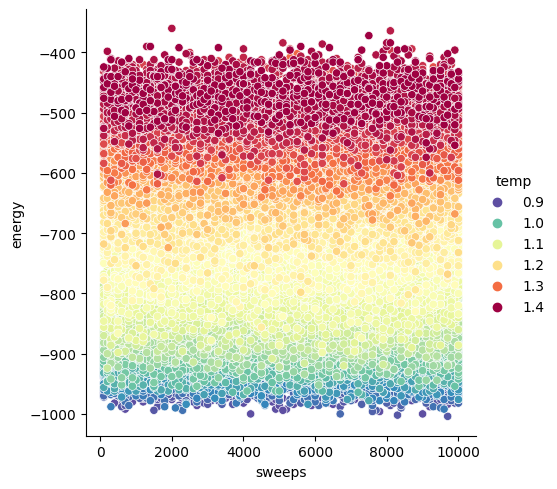

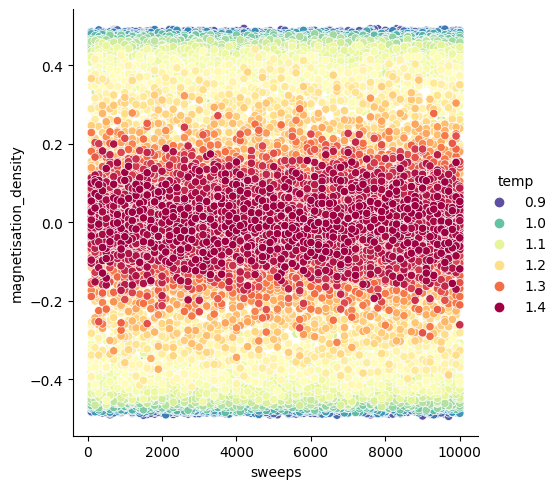

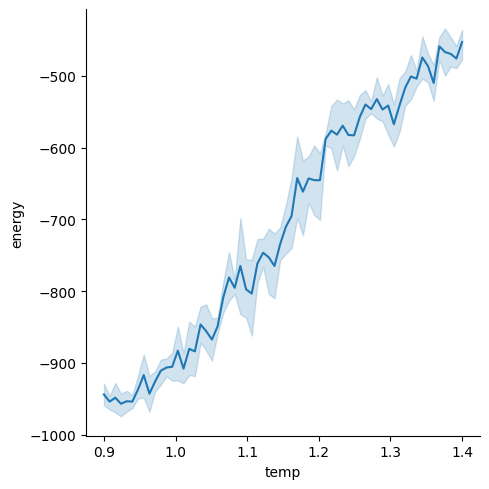

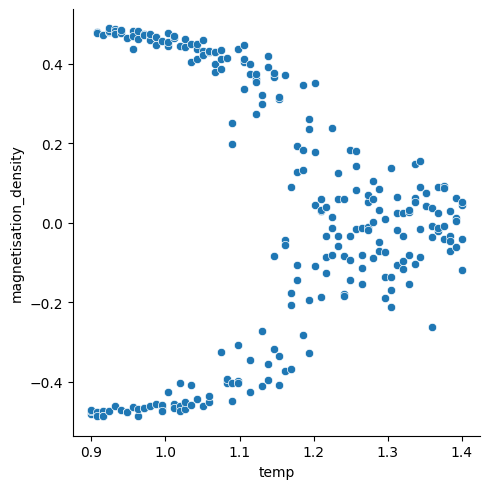

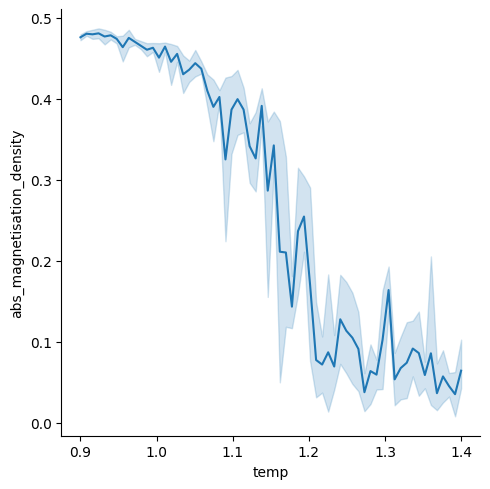

In [13]:
fig_evolve_energy_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_energy_sweeps.savefig(SAVE_PATH / "fig_evolve_energy_sweeps.png")

fig_evolve_mag_dens_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="magnetisation_density",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_mag_dens_sweeps.savefig(SAVE_PATH / "fig_evolve_mag_dens_sweeps.png")

last_sweeps = evolve_meas_df[
    evolve_meas_df["sweeps"] == np.max(evolve_meas_df["sweeps"])
]

fig_evolve_energy_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
fig_evolve_energy_temp.savefig(SAVE_PATH / "fig_evolve_energy_temp.png")

fig_evolve_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="magnetisation_density",
)
fig_evolve_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_mag_dens_temp.png")

fig_evolve_abs_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)
fig_evolve_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_abs_mag_dens_temp.png")

In [14]:
if c.plot_states:
    states_list = states.unensamble()
    temp_states = states_list[: c.n_temps]

In [15]:
if c.plot_states:

    @interact(value=0, min=0, max=len(temp_states))
    def update(i=(0, len(temp_states) - 1)):
        fig = temp_states[i].plot()
        fig.set_size_inches(10, 10)
        fig.dpi = 100

    ...

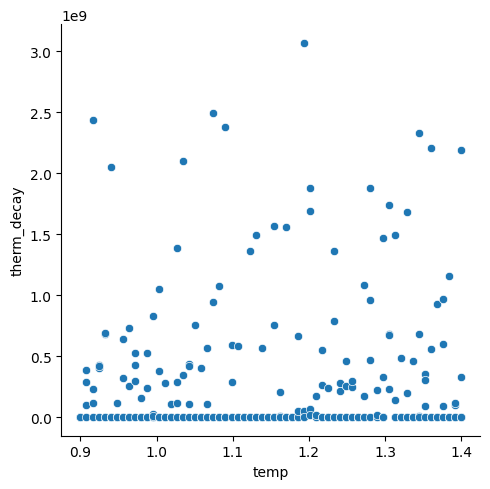

In [16]:
if c.check_thermalised:
    # Fit saturating decay times to quantifiably understand whether we have fully thermalised
    def fit_thermalisation(group):
        x = group["sweeps"]
        y = group["energy"]

        amplitude = np.max(y) - np.min(y)
        decay = np.max(x)
        offset = y.iloc[-1]

        params = SaturatingExponential.make_params()
        params["amplitude"].set(amplitude)
        params["decay"].set(decay, min=0, max=np.inf)
        params["c"].set(offset)

        fit = SaturatingExponential.fit(y, params, x=x)

        assert np.ptp(group["temp"]) == 0.0

        return pd.Series(
            {
                "temp": group["temp"].iloc[0],
                "therm_amplitude": fit.params["amplitude"].value,
                "therm_amplitude_sd": fit.params["amplitude"].stderr,
                "therm_decay": fit.params["decay"].value,
                "therm_decay_sd": fit.params["decay"].stderr,
                "therm_offset": fit.params["c"].value,
                "therm_offset_sd": fit.params["c"].stderr,
            }
        )

    evolve_meas_fit_df = evolve_meas_df.groupby("state_id", as_index=False).apply(
        fit_thermalisation
    )
    fig_evolve_therm_fit = sns.relplot(
        data=evolve_meas_fit_df,
        x="temp",
        y="therm_decay",
    )
    fig_evolve_therm_fit.savefig(SAVE_PATH / "fig_evolve_therm_fit.png")

    def _has_thermalised():
        high_temp_df = evolve_meas_fit_df[
            evolve_meas_fit_df["temp"] == evolve_meas_fit_df["temp"].max()
        ]
        therm_check_df = high_temp_df[
            high_temp_df["therm_decay"] > 4.0 * high_temp_df["therm_decay_sd"]
        ]

        # We have no data to check probably because system is very very thermalised
        # and thus has no data to fit to exponential
        if not len(therm_check_df):
            return True

        longest_decay = therm_check_df["therm_decay"].max()
        print(longest_decay)
        if evolve_meas_df["sweeps"].max() > 6.0 * longest_decay:
            return True

        return False

    has_thermalised = _has_thermalised()

    if not has_thermalised:
        raise RuntimeError("System has not fully thermalised!")

# Autocorrelation

In [17]:
if c.do_autocorrelation:

    @transforms(in_axes=(0, 0, None, None, None), out_axes=0)
    def get_autocorrelation(
        key: RNGKey, state: State, steps: int, sweeps_per_step: int, num_prints: int
    ) -> AutocorrelationData:
        keys = random.split(key, num=steps)

        def get_measurement_scan(state: State, x: RNGKey) -> tuple[State, Measurement]:
            rng_key = x
            state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
            measurement = state.measure()

            return state, measurement

        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=get_measurement_scan, init=state, xs=keys)

        acorr_energy = acf(measurements.energy)
        acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

        sweeps = jnp.arange(acorr_energy.size) * sweeps_per_step

        # Fit exponential decay to find characteristic autocorrelation time
        def exponential_decay(x, tau):
            """
            f(x) = exp(- x / τ)
            """
            return jnp.exp(-x / tau)

        # Objective function to minimise
        def objective(params, x, y, weights):
            tau = params
            trial = exponential_decay(x, tau)
            residuals = y - trial
            weighted_residuals = weights * residuals

            return jnp.sum(weighted_residuals**2)

        energy_initial_params = jnp.asarray([float(sweeps_per_step)])
        # Noise at high x (low y) dominates fit.
        # Weigh by ordinate magnitude
        energy_weights = jnp.abs(acorr_energy)
        energy_decay_time = minimize(
            objective,
            x0=energy_initial_params,
            method="BFGS",
            args=(sweeps, acorr_energy, energy_weights),
        ).x[0]

        mag_dens_initial_params = jnp.asarray([float(sweeps_per_step)])
        mag_dens_weights = jnp.abs(acorr_mag_dens)
        mag_dens_decay_time = minimize(
            objective,
            x0=mag_dens_initial_params,
            method="BFGS",
            args=(sweeps, acorr_mag_dens, mag_dens_weights),
        ).x[0]

        return AutocorrelationData(
            state=state,
            steps=steps,
            sweeps_per_step=sweeps_per_step,
            sweeps=sweeps,
            energy=acorr_energy,
            magnetisation_density=acorr_mag_dens,
            energy_decay_time=energy_decay_time,
            magnetisation_density_decay_time=mag_dens_decay_time,
        )

    keys = k.shaped(states.transformation_shape)

    autocorrelation_timer = Stopwatch.start()
    ac_data = get_autocorrelation(
        keys, states, c.autocorrelation_steps, c.autocorrelation_sweeps_per_step, 10
    )
    ac_data.block_until_ready()

    autocorrelation_time = autocorrelation_timer.time()
    to_save["autocorrelation_time"] = autocorrelation_time
    print(f"Ran autocorrelation program in: {autocorrelation_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "ac_data.eqx", ac_data)

/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function get_autocorrelation includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  0%|                                                                                     | 0/64000 [00:00<?, ?it/s]

  0%|▏                                                                        | 164/64000 [00:09<1:04:25, 16.52it/s]

  0%|▎                                                                          | 264/64000 [00:10<37:21, 28.44it/s]

  1%|▍                                                                          | 364/64000 [00:10<23:15, 45.60it/s]

  1%|▌                                                                          | 464/64000 [00:11<16:40, 63.48it/s]

  1%|▋                                                                          | 564/64000 [00:11<11:32, 91.57it/s]

  1%|▊                                                                         | 664/64000 [00:11<08:30, 124.16it/s]

  1%|▉                                                                          | 764/64000 [00:13<10:35, 99.49it/s]

  1%|▉                                                                         | 864/64000 [00:13<08:22, 125.61it/s]

  2%|█                                                                         | 964/64000 [00:13<06:39, 157.76it/s]

  2%|█▏                                                                       | 1064/64000 [00:13<05:05, 206.34it/s]

  2%|█▎                                                                       | 1164/64000 [00:14<06:13, 168.45it/s]

  2%|█▍                                                                       | 1264/64000 [00:14<05:05, 205.41it/s]

  2%|█▌                                                                       | 1364/64000 [00:15<05:13, 199.53it/s]

  2%|█▋                                                                       | 1464/64000 [00:16<07:46, 134.10it/s]

  2%|█▊                                                                       | 1564/64000 [00:17<07:44, 134.32it/s]

  3%|█▉                                                                       | 1664/64000 [00:18<08:45, 118.63it/s]

  3%|██                                                                       | 1764/64000 [00:19<09:08, 113.49it/s]

  3%|██▏                                                                      | 1864/64000 [00:19<07:24, 139.73it/s]

  3%|██▏                                                                      | 1964/64000 [00:20<05:52, 175.90it/s]

  3%|██▎                                                                      | 2064/64000 [00:20<06:00, 171.72it/s]

  4%|██▌                                                                      | 2264/64000 [00:20<03:28, 296.47it/s]

  4%|██▋                                                                      | 2364/64000 [00:22<06:29, 158.22it/s]

  4%|██▊                                                                      | 2464/64000 [00:22<05:57, 171.96it/s]

  4%|██▉                                                                      | 2564/64000 [00:23<05:45, 177.96it/s]

  4%|███                                                                      | 2664/64000 [00:24<06:27, 158.22it/s]

  4%|███▏                                                                     | 2764/64000 [00:24<05:16, 193.64it/s]

  4%|███▎                                                                     | 2864/64000 [00:24<04:29, 227.11it/s]

  5%|███▍                                                                     | 2964/64000 [00:25<06:45, 150.37it/s]

  5%|███▍                                                                     | 3064/64000 [00:25<05:26, 186.80it/s]

  5%|███▌                                                                     | 3164/64000 [00:26<06:48, 148.90it/s]

  5%|███▋                                                                     | 3264/64000 [00:27<06:01, 168.04it/s]

  5%|███▊                                                                     | 3364/64000 [00:27<05:35, 180.55it/s]

  5%|███▉                                                                     | 3464/64000 [00:28<05:05, 198.30it/s]

  6%|████                                                                     | 3564/64000 [00:29<06:40, 150.81it/s]

  6%|████▏                                                                    | 3664/64000 [00:29<05:15, 191.25it/s]

  6%|████▎                                                                    | 3764/64000 [00:30<05:49, 172.48it/s]

  6%|████▍                                                                    | 3864/64000 [00:30<04:30, 222.35it/s]

  6%|████▌                                                                    | 3964/64000 [00:30<03:55, 255.27it/s]

  6%|████▋                                                                    | 4064/64000 [00:30<03:03, 326.94it/s]

  7%|████▋                                                                    | 4164/64000 [00:31<03:40, 271.23it/s]

  7%|████▊                                                                    | 4264/64000 [00:32<05:29, 181.05it/s]

  7%|████▉                                                                    | 4364/64000 [00:33<06:34, 151.35it/s]

  7%|█████▏                                                                   | 4564/64000 [00:33<04:00, 247.18it/s]

  7%|█████▍                                                                   | 4764/64000 [00:33<03:01, 326.60it/s]

  8%|█████▌                                                                   | 4864/64000 [00:33<02:41, 366.98it/s]

  8%|█████▋                                                                   | 4964/64000 [00:34<02:40, 367.56it/s]

  8%|█████▉                                                                   | 5164/64000 [00:34<01:57, 499.49it/s]

  8%|██████                                                                   | 5264/64000 [00:34<01:44, 559.74it/s]

  8%|██████                                                                   | 5364/64000 [00:34<02:42, 360.93it/s]

  9%|██████▎                                                                  | 5564/64000 [00:35<01:53, 515.96it/s]

  9%|██████▌                                                                  | 5764/64000 [00:35<01:28, 658.13it/s]

  9%|██████▋                                                                  | 5864/64000 [00:35<02:08, 452.68it/s]

  9%|██████▊                                                                  | 5964/64000 [00:36<02:52, 335.92it/s]

  9%|██████▉                                                                  | 6064/64000 [00:36<02:28, 390.46it/s]

 10%|███████▎                                                                 | 6364/64000 [00:36<01:53, 507.25it/s]

 10%|███████▎                                                                 | 6464/64000 [00:37<02:48, 340.48it/s]

 10%|███████▍                                                                 | 6564/64000 [00:37<03:04, 312.03it/s]

 10%|███████▌                                                                 | 6664/64000 [00:38<02:39, 360.43it/s]

 11%|███████▋                                                                 | 6764/64000 [00:38<02:27, 388.32it/s]

 11%|███████▉                                                                 | 6964/64000 [00:38<01:53, 503.36it/s]

 11%|████████                                                                 | 7064/64000 [00:38<02:15, 418.76it/s]

 11%|████████▏                                                                | 7164/64000 [00:39<02:03, 458.99it/s]

 12%|████████▍                                                                | 7364/64000 [00:39<02:07, 444.18it/s]

 12%|████████▌                                                                | 7464/64000 [00:39<02:20, 401.12it/s]

 12%|████████▋                                                                | 7564/64000 [00:40<02:37, 358.44it/s]

 12%|████████▊                                                                | 7764/64000 [00:40<02:04, 451.66it/s]

 13%|█████████▏                                                               | 8064/64000 [00:40<01:32, 607.15it/s]

 13%|█████████▎                                                               | 8164/64000 [00:42<03:22, 276.38it/s]

 13%|█████████▌                                                               | 8364/64000 [00:42<02:22, 390.39it/s]

 13%|█████████▋                                                               | 8464/64000 [00:42<02:05, 442.42it/s]

 13%|█████████▊                                                               | 8564/64000 [00:42<03:08, 294.60it/s]

 14%|█████████▉                                                               | 8664/64000 [00:43<02:52, 321.62it/s]

 14%|██████████                                                               | 8864/64000 [00:43<02:03, 446.99it/s]

 14%|██████████▏                                                              | 8964/64000 [00:44<03:01, 302.54it/s]

 14%|██████████▎                                                              | 9064/64000 [00:44<03:26, 265.72it/s]

 14%|██████████▍                                                              | 9164/64000 [00:44<03:09, 289.60it/s]

 14%|██████████▌                                                              | 9264/64000 [00:45<02:43, 335.04it/s]

 15%|██████████▋                                                              | 9364/64000 [00:45<02:24, 378.02it/s]

 15%|██████████▉                                                              | 9564/64000 [00:46<03:31, 257.67it/s]

 15%|███████████                                                              | 9664/64000 [00:46<03:11, 284.24it/s]

 15%|███████████▏                                                             | 9764/64000 [00:47<03:57, 228.14it/s]

 16%|███████████▎                                                            | 10064/64000 [00:47<02:20, 383.22it/s]

 16%|███████████▍                                                            | 10164/64000 [00:47<02:08, 418.10it/s]

 16%|███████████▌                                                            | 10264/64000 [00:48<03:39, 245.09it/s]

 16%|███████████▋                                                            | 10364/64000 [00:48<03:02, 294.03it/s]

 16%|███████████▊                                                            | 10464/64000 [00:49<04:12, 212.08it/s]

 17%|███████████▉                                                            | 10564/64000 [00:50<05:04, 175.65it/s]

 17%|███████████▉                                                            | 10664/64000 [00:50<04:47, 185.34it/s]

 17%|████████████▏                                                           | 10864/64000 [00:51<02:52, 308.68it/s]

 17%|████████████▎                                                           | 10964/64000 [00:51<03:32, 249.81it/s]

 17%|████████████▌                                                           | 11164/64000 [00:53<05:17, 166.28it/s]

 18%|████████████▋                                                           | 11264/64000 [00:53<04:35, 191.21it/s]

 18%|████████████▊                                                           | 11364/64000 [00:54<04:14, 206.78it/s]

 18%|████████████▉                                                           | 11464/64000 [00:54<04:37, 189.06it/s]

 18%|█████████████                                                           | 11564/64000 [00:54<03:41, 236.63it/s]

 18%|█████████████                                                           | 11664/64000 [00:55<04:18, 202.18it/s]

 18%|█████████████▏                                                          | 11764/64000 [00:57<07:44, 112.38it/s]

 19%|█████████████▎                                                          | 11864/64000 [00:57<06:33, 132.41it/s]

 19%|█████████████▌                                                          | 12064/64000 [00:58<04:23, 197.14it/s]

 19%|█████████████▋                                                          | 12164/64000 [00:58<03:45, 230.00it/s]

 19%|█████████████▊                                                          | 12264/64000 [00:58<03:45, 229.19it/s]

 19%|█████████████▉                                                          | 12364/64000 [00:59<03:15, 264.60it/s]

 19%|██████████████                                                          | 12464/64000 [01:00<04:53, 175.41it/s]

 20%|██████████████▏                                                         | 12564/64000 [01:00<03:45, 228.08it/s]

 20%|██████████████▌                                                         | 12964/64000 [01:02<04:41, 181.27it/s]

 20%|██████████████▋                                                         | 13064/64000 [01:03<04:27, 190.49it/s]

 21%|██████████████▊                                                         | 13164/64000 [01:04<04:55, 172.23it/s]

 21%|██████████████▉                                                         | 13264/64000 [01:05<06:52, 122.87it/s]

 21%|███████████████                                                         | 13364/64000 [01:05<05:32, 152.09it/s]

 21%|███████████████▏                                                        | 13464/64000 [01:06<05:44, 146.54it/s]

 21%|███████████████▎                                                        | 13564/64000 [01:06<04:57, 169.80it/s]

 21%|███████████████▎                                                        | 13664/64000 [01:07<04:38, 180.71it/s]

 22%|███████████████▍                                                        | 13764/64000 [01:07<03:40, 228.16it/s]

 22%|███████████████▌                                                        | 13864/64000 [01:07<03:11, 261.59it/s]

 22%|███████████████▋                                                        | 13964/64000 [01:08<03:48, 218.93it/s]

 22%|███████████████▉                                                        | 14164/64000 [01:08<02:17, 361.81it/s]

 22%|████████████████                                                        | 14264/64000 [01:09<02:50, 291.18it/s]

 23%|████████████████▎                                                       | 14464/64000 [01:09<02:18, 357.16it/s]

 23%|████████████████▍                                                       | 14564/64000 [01:09<02:14, 367.15it/s]

 23%|████████████████▍                                                       | 14664/64000 [01:10<02:32, 323.55it/s]

 23%|████████████████▋                                                       | 14864/64000 [01:10<02:09, 379.35it/s]

 23%|████████████████▊                                                       | 14964/64000 [01:10<02:08, 380.19it/s]

 24%|████████████████▉                                                       | 15064/64000 [01:11<02:19, 350.51it/s]

 24%|█████████████████                                                       | 15164/64000 [01:11<02:05, 388.11it/s]

 24%|█████████████████▏                                                      | 15264/64000 [01:11<01:56, 416.75it/s]

 24%|█████████████████▎                                                      | 15364/64000 [01:12<02:34, 314.24it/s]

 24%|█████████████████▍                                                      | 15464/64000 [01:12<02:21, 342.50it/s]

 24%|█████████████████▌                                                      | 15564/64000 [01:12<02:08, 376.22it/s]

 24%|█████████████████▌                                                      | 15664/64000 [01:12<02:21, 342.19it/s]

 25%|█████████████████▋                                                      | 15764/64000 [01:12<01:57, 410.87it/s]

 25%|█████████████████▊                                                      | 15864/64000 [01:13<02:00, 399.32it/s]

 25%|█████████████████▉                                                      | 15964/64000 [01:13<02:50, 281.56it/s]

 25%|██████████████████                                                      | 16064/64000 [01:14<02:30, 318.14it/s]

 25%|██████████████████▎                                                     | 16264/64000 [01:15<03:13, 247.03it/s]

 26%|██████████████████▍                                                     | 16364/64000 [01:15<03:00, 264.19it/s]

 26%|██████████████████▋                                                     | 16664/64000 [01:15<01:44, 453.53it/s]

 26%|██████████████████▊                                                     | 16764/64000 [01:16<02:25, 324.49it/s]

 26%|██████████████████▉                                                     | 16864/64000 [01:16<02:49, 277.72it/s]

 27%|███████████████████                                                     | 16964/64000 [01:17<02:58, 262.98it/s]

 27%|███████████████████▏                                                    | 17064/64000 [01:17<02:55, 267.68it/s]

 27%|███████████████████▌                                                    | 17364/64000 [01:17<01:39, 468.44it/s]

 27%|███████████████████▋                                                    | 17464/64000 [01:18<02:00, 386.47it/s]

 27%|███████████████████▊                                                    | 17564/64000 [01:18<02:43, 283.75it/s]

 28%|███████████████████▊                                                    | 17664/64000 [01:19<02:39, 290.27it/s]

 28%|███████████████████▉                                                    | 17764/64000 [01:19<02:32, 302.41it/s]

 28%|████████████████████                                                    | 17864/64000 [01:19<02:10, 352.24it/s]

 28%|████████████████████▏                                                   | 17964/64000 [01:19<02:07, 362.36it/s]

 28%|████████████████████▎                                                   | 18064/64000 [01:20<02:00, 381.53it/s]

 28%|████████████████████▍                                                   | 18164/64000 [01:20<01:55, 396.71it/s]

 29%|████████████████████▌                                                   | 18264/64000 [01:20<02:32, 299.20it/s]

 29%|████████████████████▋                                                   | 18364/64000 [01:21<02:13, 341.93it/s]

 29%|████████████████████▊                                                   | 18464/64000 [01:21<02:37, 288.24it/s]

 29%|████████████████████▉                                                   | 18564/64000 [01:22<02:58, 254.02it/s]

 29%|████████████████████▉                                                   | 18664/64000 [01:22<02:56, 256.83it/s]

 29%|█████████████████████                                                   | 18764/64000 [01:23<04:24, 171.30it/s]

 30%|█████████████████████▎                                                  | 18964/64000 [01:25<05:02, 149.07it/s]

 30%|█████████████████████▍                                                  | 19064/64000 [01:25<05:01, 149.14it/s]

 30%|█████████████████████▊                                                  | 19364/64000 [01:26<03:03, 242.65it/s]

 30%|█████████████████████▉                                                  | 19464/64000 [01:26<03:04, 240.81it/s]

 31%|██████████████████████                                                  | 19564/64000 [01:27<03:44, 198.21it/s]

 31%|██████████████████████▏                                                 | 19764/64000 [01:27<02:38, 278.31it/s]

 31%|██████████████████████▌                                                 | 20063/64000 [01:27<01:41, 432.58it/s]

 32%|██████████████████████▋                                                 | 20163/64000 [01:28<02:17, 318.41it/s]

 32%|██████████████████████▊                                                 | 20263/64000 [01:29<03:27, 210.79it/s]

 32%|███████████████████████                                                 | 20463/64000 [01:30<03:14, 224.29it/s]

 32%|███████████████████████▏                                                | 20563/64000 [01:30<03:09, 229.23it/s]

 32%|███████████████████████▏                                                | 20663/64000 [01:31<02:46, 260.17it/s]

 33%|███████████████████████▌                                                | 20963/64000 [01:32<02:45, 259.28it/s]

 33%|███████████████████████▋                                                | 21063/64000 [01:32<02:45, 259.52it/s]

 33%|███████████████████████▊                                                | 21163/64000 [01:32<02:23, 299.35it/s]

 34%|████████████████████████▏                                               | 21462/64000 [01:33<02:03, 343.28it/s]

 34%|████████████████████████▎                                               | 21562/64000 [01:34<02:48, 252.24it/s]

 34%|████████████████████████▎                                               | 21662/64000 [01:34<02:49, 250.44it/s]

 34%|████████████████████████▍                                               | 21762/64000 [01:35<03:12, 219.22it/s]

 34%|████████████████████████▌                                               | 21862/64000 [01:35<03:15, 215.18it/s]

 34%|████████████████████████▋                                               | 21962/64000 [01:36<03:05, 226.65it/s]

 34%|████████████████████████▊                                               | 22062/64000 [01:36<02:40, 261.70it/s]

 35%|████████████████████████▉                                               | 22162/64000 [01:36<02:16, 306.34it/s]

 35%|█████████████████████████                                               | 22261/64000 [01:36<02:02, 340.26it/s]

 35%|█████████████████████████▎                                              | 22461/64000 [01:38<03:34, 193.65it/s]

 35%|█████████████████████████▍                                              | 22561/64000 [01:38<02:55, 235.80it/s]

 35%|█████████████████████████▍                                              | 22661/64000 [01:39<02:52, 239.37it/s]

 36%|█████████████████████████▌                                              | 22760/64000 [01:39<02:17, 299.47it/s]

 36%|█████████████████████████▋                                              | 22860/64000 [01:39<02:10, 315.19it/s]

 36%|█████████████████████████▊                                              | 22960/64000 [01:39<02:30, 273.57it/s]

 36%|█████████████████████████▉                                              | 23060/64000 [01:40<02:43, 250.94it/s]

 36%|██████████████████████████▏                                             | 23260/64000 [01:40<01:59, 340.23it/s]

 36%|██████████████████████████▎                                             | 23360/64000 [01:40<01:44, 390.38it/s]

 37%|██████████████████████████▍                                             | 23460/64000 [01:41<02:37, 258.13it/s]

 37%|██████████████████████████▌                                             | 23560/64000 [01:42<02:57, 227.55it/s]

 37%|██████████████████████████▌                                             | 23660/64000 [01:42<02:21, 284.12it/s]

2023-04-26 18:08:54.981576: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=0, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 37%|██████████████████████████▋                                             | 23760/64000 [01:42<02:40, 251.30it/s]

 37%|██████████████████████████▊                                             | 23860/64000 [01:43<02:25, 275.25it/s]

 38%|███████████████████████████                                             | 24060/64000 [01:43<01:36, 412.42it/s]

 38%|███████████████████████████▏                                            | 24160/64000 [01:44<03:02, 218.84it/s]

 38%|███████████████████████████▍                                            | 24359/64000 [01:44<01:59, 331.36it/s]

 38%|███████████████████████████▌                                            | 24459/64000 [01:44<02:03, 319.54it/s]

 38%|███████████████████████████▋                                            | 24559/64000 [01:45<01:55, 342.36it/s]

 39%|███████████████████████████▋                                            | 24659/64000 [01:45<01:41, 388.15it/s]

 39%|███████████████████████████▊                                            | 24759/64000 [01:45<01:38, 396.67it/s]

 39%|███████████████████████████▉                                            | 24859/64000 [01:45<01:22, 474.53it/s]

 39%|████████████████████████████                                            | 24959/64000 [01:46<02:24, 269.70it/s]

 39%|████████████████████████████▏                                           | 25059/64000 [01:46<02:24, 269.84it/s]

2023-04-26 18:09:00.196969: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=1, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}



 39%|████████████████████████████▎                                           | 25159/64000 [01:47<03:22, 191.58it/s]

 39%|████████████████████████████▍                                           | 25259/64000 [01:48<03:39, 176.11it/s]

 40%|████████████████████████████▊                                           | 25559/64000 [01:49<03:00, 212.84it/s]

 40%|████████████████████████████▉                                           | 25758/64000 [01:49<02:20, 271.74it/s]

 40%|█████████████████████████████                                           | 25858/64000 [01:50<02:01, 315.00it/s]

 41%|█████████████████████████████▎                                          | 26058/64000 [01:51<02:57, 213.93it/s]

 41%|█████████████████████████████▍                                          | 26158/64000 [01:52<03:10, 198.17it/s]

 41%|█████████████████████████████▌                                          | 26258/64000 [01:52<02:49, 222.10it/s]

2023-04-26 18:09:05.334405: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=2, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 41%|█████████████████████████████▋                                          | 26358/64000 [01:53<03:09, 198.84it/s]

 41%|█████████████████████████████▊                                          | 26458/64000 [01:53<02:39, 235.03it/s]

 41%|█████████████████████████████▉                                          | 26557/64000 [01:53<02:12, 283.41it/s]

 42%|█████████████████████████████▉                                          | 26657/64000 [01:53<02:31, 246.71it/s]

 42%|██████████████████████████████                                          | 26757/64000 [01:54<03:11, 194.77it/s]

2023-04-26 18:09:07.394643: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=3, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 42%|██████████████████████████████▏                                         | 26857/64000 [01:54<02:37, 235.29it/s]

 42%|██████████████████████████████▎                                         | 26957/64000 [01:55<02:14, 275.40it/s]

 42%|██████████████████████████████▍                                         | 27057/64000 [01:56<03:39, 168.32it/s]

 43%|██████████████████████████████▋                                         | 27257/64000 [01:57<03:26, 178.09it/s]

 43%|██████████████████████████████▊                                         | 27357/64000 [01:57<02:45, 221.28it/s]

 43%|██████████████████████████████▉                                         | 27457/64000 [01:57<02:47, 218.29it/s]

 43%|███████████████████████████████                                         | 27556/64000 [01:58<02:15, 269.95it/s]

 43%|███████████████████████████████                                         | 27656/64000 [01:58<02:07, 284.07it/s]

 43%|███████████████████████████████▏                                        | 27756/64000 [01:59<03:05, 195.04it/s]

 44%|███████████████████████████████▍                                        | 27956/64000 [01:59<02:04, 289.74it/s]

 44%|███████████████████████████████▋                                        | 28156/64000 [02:00<01:53, 315.68it/s]

 44%|███████████████████████████████▊                                        | 28256/64000 [02:00<01:56, 307.24it/s]

2023-04-26 18:09:13.283163: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=4, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 44%|███████████████████████████████▉                                        | 28356/64000 [02:01<02:17, 258.64it/s]

 44%|████████████████████████████████                                        | 28456/64000 [02:01<02:15, 261.60it/s]

 45%|████████████████████████████████▏                                       | 28556/64000 [02:01<01:49, 322.94it/s]

 45%|████████████████████████████████▎                                       | 28755/64000 [02:02<01:43, 339.46it/s]

 45%|████████████████████████████████▍                                       | 28855/64000 [02:02<01:53, 310.91it/s]

 45%|████████████████████████████████▌                                       | 28955/64000 [02:03<03:29, 166.96it/s]

 45%|████████████████████████████████▋                                       | 29055/64000 [02:04<03:52, 150.24it/s]

 46%|████████████████████████████████▊                                       | 29155/64000 [02:05<03:14, 178.78it/s]

 46%|████████████████████████████████▉                                       | 29255/64000 [02:05<02:30, 231.32it/s]

2023-04-26 18:09:18.874012: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=5, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 46%|█████████████████████████████████▍                                       | 29355/64000 [02:07<05:47, 99.79it/s]

 46%|█████████████████████████████████▏                                      | 29455/64000 [02:08<04:56, 116.57it/s]

 46%|█████████████████████████████████▎                                      | 29654/64000 [02:08<03:13, 177.40it/s]

 46%|█████████████████████████████████▍                                      | 29754/64000 [02:09<03:52, 147.13it/s]

2023-04-26 18:09:24.191441: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=6, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}



 47%|██████████████████████████████████                                       | 29854/64000 [02:11<06:04, 93.57it/s]

 47%|█████████████████████████████████▋                                      | 29953/64000 [02:11<04:41, 121.15it/s]

 47%|█████████████████████████████████▊                                      | 30053/64000 [02:12<03:57, 142.75it/s]

 47%|█████████████████████████████████▉                                      | 30153/64000 [02:12<03:12, 175.38it/s]

 47%|██████████████████████████████████                                      | 30253/64000 [02:13<03:36, 155.87it/s]

 48%|██████████████████████████████████▎                                     | 30453/64000 [02:13<02:13, 250.67it/s]

 48%|██████████████████████████████████▎                                     | 30553/64000 [02:15<03:38, 152.78it/s]

2023-04-26 18:09:27.703128: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=7, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}



 48%|██████████████████████████████████▍                                     | 30653/64000 [02:15<02:55, 190.45it/s]

 48%|██████████████████████████████████▌                                     | 30753/64000 [02:15<02:19, 238.04it/s]

 48%|██████████████████████████████████▊                                     | 30952/64000 [02:15<02:06, 261.39it/s]

 49%|██████████████████████████████████▉                                     | 31052/64000 [02:16<01:49, 300.92it/s]

 49%|███████████████████████████████████                                     | 31152/64000 [02:16<01:44, 313.71it/s]

 49%|███████████████████████████████████▏                                    | 31252/64000 [02:16<01:55, 284.13it/s]

 49%|███████████████████████████████████▍                                    | 31452/64000 [02:17<01:15, 429.05it/s]

 49%|███████████████████████████████████▌                                    | 31652/64000 [02:18<02:04, 259.04it/s]

 50%|███████████████████████████████████▋                                    | 31752/64000 [02:18<02:10, 246.55it/s]

 50%|███████████████████████████████████▊                                    | 31852/64000 [02:20<03:18, 162.30it/s]

 50%|████████████████████████████████████                                    | 32052/64000 [02:20<02:06, 252.45it/s]

 50%|████████████████████████████████████▎                                   | 32252/64000 [02:20<01:27, 362.95it/s]

2023-04-26 18:09:33.128262: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=8, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}



 51%|████████████████████████████████████▍                                   | 32352/64000 [02:20<01:34, 335.69it/s]

 51%|████████████████████████████████████▌                                   | 32452/64000 [02:20<01:32, 339.86it/s]

 51%|████████████████████████████████████▌                                   | 32552/64000 [02:21<01:38, 318.93it/s]

 51%|████████████████████████████████████▋                                   | 32652/64000 [02:21<01:56, 268.72it/s]

 51%|████████████████████████████████████▊                                   | 32752/64000 [02:22<01:42, 304.60it/s]

 51%|████████████████████████████████████▉                                   | 32852/64000 [02:22<02:21, 219.43it/s]

 51%|█████████████████████████████████████                                   | 32952/64000 [02:23<01:52, 275.89it/s]

 52%|█████████████████████████████████████▏                                  | 33051/64000 [02:23<01:29, 347.41it/s]

 52%|█████████████████████████████████████▎                                  | 33151/64000 [02:23<02:18, 223.01it/s]

 52%|█████████████████████████████████████▍                                  | 33251/64000 [02:24<02:36, 195.95it/s]

 52%|█████████████████████████████████████▌                                  | 33351/64000 [02:24<02:19, 220.37it/s]

 52%|█████████████████████████████████████▋                                  | 33451/64000 [02:25<02:44, 185.98it/s]

 52%|█████████████████████████████████████▋                                  | 33551/64000 [02:26<02:34, 196.66it/s]

 53%|█████████████████████████████████████▊                                  | 33651/64000 [02:26<02:04, 243.69it/s]

2023-04-26 18:09:39.720625: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=9, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}



 53%|█████████████████████████████████████▉                                  | 33751/64000 [02:27<02:51, 176.01it/s]

 53%|██████████████████████████████████████                                  | 33851/64000 [02:27<02:44, 183.80it/s]

 53%|██████████████████████████████████████▏                                 | 33951/64000 [02:27<02:09, 231.29it/s]

 53%|██████████████████████████████████████▎                                 | 34051/64000 [02:29<03:16, 152.49it/s]

 53%|██████████████████████████████████████▍                                 | 34151/64000 [02:29<03:29, 142.81it/s]

 54%|██████████████████████████████████████▌                                 | 34251/64000 [02:30<04:02, 122.87it/s]

2023-04-26 18:09:43.690760: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=10, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 54%|██████████████████████████████████████▋                                 | 34351/64000 [02:31<03:16, 151.19it/s]

 54%|██████████████████████████████████████▊                                 | 34450/64000 [02:31<02:41, 183.29it/s]

 54%|██████████████████████████████████████▊                                 | 34550/64000 [02:31<02:24, 203.11it/s]

 54%|██████████████████████████████████████▉                                 | 34650/64000 [02:33<03:42, 131.67it/s]

 54%|███████████████████████████████████████                                 | 34750/64000 [02:34<03:58, 122.83it/s]

 54%|███████████████████████████████████████▏                                | 34850/64000 [02:34<03:36, 134.44it/s]

 55%|███████████████████████████████████████▎                                | 34950/64000 [02:35<02:55, 165.90it/s]

 55%|███████████████████████████████████████▍                                | 35050/64000 [02:35<02:52, 167.85it/s]

2023-04-26 18:09:48.689392: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=11, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}



 55%|███████████████████████████████████████▌                                | 35150/64000 [02:36<02:46, 173.46it/s]

 55%|███████████████████████████████████████▋                                | 35250/64000 [02:36<02:46, 172.53it/s]

 55%|███████████████████████████████████████▊                                | 35350/64000 [02:37<02:49, 168.66it/s]

 55%|███████████████████████████████████████▉                                | 35450/64000 [02:37<02:16, 209.50it/s]

 56%|████████████████████████████████████████                                | 35649/64000 [02:37<01:24, 334.36it/s]

 56%|████████████████████████████████████████▏                               | 35749/64000 [02:40<04:26, 105.84it/s]

 56%|████████████████████████████████████████▎                               | 35848/64000 [02:40<03:28, 134.89it/s]

 56%|████████████████████████████████████████▍                               | 35948/64000 [02:41<03:32, 131.73it/s]

 56%|████████████████████████████████████████▌                               | 36048/64000 [02:41<02:46, 167.40it/s]

 56%|████████████████████████████████████████▋                               | 36148/64000 [02:42<02:14, 207.17it/s]

2023-04-26 18:09:55.900980: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=12, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 57%|█████████████████████████████████████████▎                               | 36248/64000 [02:45<06:16, 73.67it/s]

 57%|█████████████████████████████████████████▍                               | 36348/64000 [02:45<04:53, 94.27it/s]

 57%|█████████████████████████████████████████                               | 36448/64000 [02:45<03:34, 128.57it/s]

 57%|█████████████████████████████████████████                               | 36548/64000 [02:46<03:10, 143.97it/s]

 57%|█████████████████████████████████████████▏                              | 36648/64000 [02:47<03:01, 150.63it/s]

 57%|█████████████████████████████████████████▎                              | 36748/64000 [02:47<03:19, 136.74it/s]

 58%|█████████████████████████████████████████▍                              | 36848/64000 [02:48<03:00, 150.48it/s]

 58%|█████████████████████████████████████████▌                              | 36948/64000 [02:48<02:39, 169.45it/s]

 58%|█████████████████████████████████████████▋                              | 37048/64000 [02:49<02:34, 174.57it/s]

 58%|█████████████████████████████████████████▊                              | 37148/64000 [02:49<02:09, 207.81it/s]

 58%|██████████████████████████████████████████                              | 37348/64000 [02:50<01:33, 286.03it/s]

 59%|██████████████████████████████████████████▏                             | 37448/64000 [02:51<02:17, 193.74it/s]

2023-04-26 18:10:04.322741: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=13, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 59%|██████████████████████████████████████████▏                             | 37548/64000 [02:52<03:02, 145.15it/s]

 59%|██████████████████████████████████████████▎                             | 37648/64000 [02:53<04:03, 108.33it/s]

 59%|██████████████████████████████████████████▍                             | 37748/64000 [02:54<03:27, 126.32it/s]

 59%|██████████████████████████████████████████▌                             | 37848/64000 [02:54<02:52, 151.26it/s]

 59%|██████████████████████████████████████████▋                             | 37948/64000 [02:55<02:55, 148.46it/s]

 59%|██████████████████████████████████████████▊                             | 38047/64000 [02:55<02:20, 185.18it/s]

 60%|██████████████████████████████████████████▉                             | 38147/64000 [02:56<02:23, 180.35it/s]

 60%|███████████████████████████████████████████                             | 38247/64000 [02:56<02:41, 159.44it/s]

 60%|███████████████████████████████████████████▏                            | 38347/64000 [02:57<02:27, 173.90it/s]

 60%|███████████████████████████████████████████▎                            | 38446/64000 [02:57<02:02, 208.49it/s]

 60%|███████████████████████████████████████████▎                            | 38546/64000 [02:58<03:10, 133.48it/s]

 60%|███████████████████████████████████████████▍                            | 38646/64000 [02:59<02:56, 143.71it/s]

 61%|███████████████████████████████████████████▌                            | 38746/64000 [02:59<02:12, 190.69it/s]

 61%|███████████████████████████████████████████▊                            | 38946/64000 [03:00<01:32, 272.21it/s]

2023-04-26 18:10:12.976100: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=14, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}



 61%|███████████████████████████████████████████▉                            | 39046/64000 [03:00<01:41, 246.03it/s]

 61%|████████████████████████████████████████████                            | 39146/64000 [03:00<01:30, 273.85it/s]

 61%|████████████████████████████████████████████▏                           | 39246/64000 [03:01<01:30, 272.80it/s]

 61%|████████████████████████████████████████████▎                           | 39346/64000 [03:01<01:16, 323.33it/s]

2023-04-26 18:10:14.560413: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=15, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 62%|████████████████████████████████████████████▍                           | 39446/64000 [03:02<02:01, 202.43it/s]

 62%|████████████████████████████████████████████▍                           | 39546/64000 [03:04<03:26, 118.45it/s]

 62%|████████████████████████████████████████████▌                           | 39646/64000 [03:04<03:00, 134.58it/s]

 62%|████████████████████████████████████████████▋                           | 39746/64000 [03:04<02:26, 166.02it/s]

 62%|████████████████████████████████████████████▊                           | 39846/64000 [03:04<01:53, 212.87it/s]

 62%|████████████████████████████████████████████▉                           | 39946/64000 [03:05<01:51, 216.32it/s]

 63%|█████████████████████████████████████████████                           | 40046/64000 [03:06<02:16, 175.31it/s]

 63%|█████████████████████████████████████████████▏                          | 40146/64000 [03:07<03:03, 129.93it/s]

 63%|█████████████████████████████████████████████▎                          | 40246/64000 [03:08<02:53, 137.05it/s]

 63%|█████████████████████████████████████████████▍                          | 40346/64000 [03:08<02:17, 171.49it/s]

 63%|█████████████████████████████████████████████▌                          | 40446/64000 [03:09<02:31, 155.16it/s]

 63%|█████████████████████████████████████████████▌                          | 40546/64000 [03:09<02:48, 139.05it/s]

 64%|█████████████████████████████████████████████▊                          | 40745/64000 [03:11<02:48, 138.03it/s]

 64%|█████████████████████████████████████████████▉                          | 40845/64000 [03:12<02:41, 143.34it/s]

 64%|██████████████████████████████████████████████▋                          | 40945/64000 [03:14<04:54, 78.24it/s]

 64%|██████████████████████████████████████████████▊                          | 41045/64000 [03:16<05:04, 75.28it/s]

 64%|██████████████████████████████████████████████▍                         | 41245/64000 [03:17<03:24, 111.39it/s]

 65%|██████████████████████████████████████████████▌                         | 41345/64000 [03:17<03:04, 123.07it/s]

2023-04-26 18:10:30.812216: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=16, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 65%|██████████████████████████████████████████████▋                         | 41445/64000 [03:18<03:13, 116.45it/s]

 65%|██████████████████████████████████████████████▋                         | 41545/64000 [03:18<02:29, 150.42it/s]

 65%|██████████████████████████████████████████████▊                         | 41645/64000 [03:19<02:17, 162.08it/s]

 65%|██████████████████████████████████████████████▉                         | 41745/64000 [03:21<03:40, 101.01it/s]

2023-04-26 18:10:33.946091: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=17, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 65%|███████████████████████████████████████████████                         | 41845/64000 [03:21<03:25, 107.79it/s]

 66%|███████████████████████████████████████████████▏                        | 41945/64000 [03:22<02:58, 123.68it/s]

 66%|███████████████████████████████████████████████▍                        | 42145/64000 [03:23<02:37, 139.19it/s]

 66%|███████████████████████████████████████████████▋                        | 42344/64000 [03:24<01:50, 195.62it/s]

 66%|███████████████████████████████████████████████▋                        | 42444/64000 [03:24<01:35, 226.38it/s]

 67%|███████████████████████████████████████████████▉                        | 42644/64000 [03:26<02:29, 143.07it/s]

 67%|████████████████████████████████████████████████                        | 42744/64000 [03:26<02:02, 173.22it/s]

 67%|████████████████████████████████████████████████▏                       | 42844/64000 [03:27<02:22, 148.73it/s]

 67%|████████████████████████████████████████████████▎                       | 42944/64000 [03:28<02:26, 143.51it/s]

 67%|████████████████████████████████████████████████▍                       | 43044/64000 [03:29<03:03, 114.07it/s]

 67%|████████████████████████████████████████████████▌                       | 43144/64000 [03:30<03:04, 112.84it/s]

 68%|████████████████████████████████████████████████▋                       | 43244/64000 [03:30<02:25, 142.54it/s]

 68%|████████████████████████████████████████████████▊                       | 43344/64000 [03:32<03:24, 100.78it/s]

 68%|████████████████████████████████████████████████▊                       | 43443/64000 [03:32<02:37, 130.77it/s]

 68%|████████████████████████████████████████████████▉                       | 43543/64000 [03:32<01:56, 175.03it/s]

 68%|█████████████████████████████████████████████████                       | 43643/64000 [03:33<01:39, 205.36it/s]

 68%|█████████████████████████████████████████████████▏                      | 43743/64000 [03:33<01:31, 220.69it/s]

 69%|█████████████████████████████████████████████████▎                      | 43843/64000 [03:33<01:21, 246.81it/s]

 69%|█████████████████████████████████████████████████▍                      | 43943/64000 [03:34<01:35, 210.23it/s]

2023-04-26 18:10:47.229590: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=18, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 69%|██████████████████████████████████████████████████▏                      | 44043/64000 [03:37<04:02, 82.26it/s]

 69%|█████████████████████████████████████████████████▊                      | 44243/64000 [03:37<02:18, 142.96it/s]

 69%|█████████████████████████████████████████████████▉                      | 44343/64000 [03:38<02:04, 158.04it/s]

 69%|█████████████████████████████████████████████████▉                      | 44443/64000 [03:39<03:04, 106.15it/s]

 70%|██████████████████████████████████████████████████▊                      | 44543/64000 [03:41<04:00, 81.06it/s]

 70%|██████████████████████████████████████████████████▉                      | 44643/64000 [03:42<03:34, 90.25it/s]

 70%|███████████████████████████████████████████████████                      | 44743/64000 [03:43<03:32, 90.45it/s]

 70%|██████████████████████████████████████████████████▍                     | 44842/64000 [03:44<02:51, 111.42it/s]

 70%|██████████████████████████████████████████████████▌                     | 44942/64000 [03:44<02:40, 119.01it/s]

 70%|██████████████████████████████████████████████████▋                     | 45042/64000 [03:45<02:10, 145.53it/s]

 71%|██████████████████████████████████████████████████▊                     | 45142/64000 [03:45<02:03, 152.19it/s]

 71%|██████████████████████████████████████████████████▉                     | 45242/64000 [03:45<01:35, 195.44it/s]

 71%|███████████████████████████████████████████████████                     | 45342/64000 [03:47<02:21, 131.95it/s]

 71%|███████████████████████████████████████████████████                     | 45442/64000 [03:47<02:09, 143.72it/s]

 71%|███████████████████████████████████████████████████▏                    | 45542/64000 [03:48<02:01, 152.35it/s]

 71%|███████████████████████████████████████████████████▎                    | 45642/64000 [03:49<02:16, 134.71it/s]

 71%|███████████████████████████████████████████████████▍                    | 45742/64000 [03:50<02:14, 135.69it/s]

 72%|███████████████████████████████████████████████████▌                    | 45842/64000 [03:50<02:02, 148.84it/s]

2023-04-26 18:11:04.723103: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=19, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 72%|███████████████████████████████████████████████████▊                    | 46042/64000 [03:52<02:25, 123.73it/s]

 72%|███████████████████████████████████████████████████▉                    | 46142/64000 [03:52<02:07, 140.57it/s]

 72%|████████████████████████████████████████████████████                    | 46242/64000 [03:54<02:50, 104.35it/s]

 72%|████████████████████████████████████████████████████▏                   | 46342/64000 [03:54<02:19, 126.37it/s]

 73%|████████████████████████████████████████████████████▏                   | 46442/64000 [03:56<02:43, 107.53it/s]

 73%|████████████████████████████████████████████████████▎                   | 46542/64000 [03:56<02:04, 140.57it/s]

 73%|████████████████████████████████████████████████████▍                   | 46642/64000 [03:57<01:59, 145.15it/s]

 73%|████████████████████████████████████████████████████▋                   | 46841/64000 [03:57<01:14, 229.06it/s]

 73%|████████████████████████████████████████████████████▊                   | 46941/64000 [03:59<02:17, 123.94it/s]

 74%|█████████████████████████████████████████████████████                   | 47141/64000 [03:59<01:32, 181.49it/s]

2023-04-26 18:11:12.379986: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=20, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 74%|█████████████████████████████████████████████████████▏                  | 47241/64000 [04:00<01:27, 191.59it/s]

 74%|█████████████████████████████████████████████████████▎                  | 47341/64000 [04:00<01:16, 219.12it/s]

 74%|█████████████████████████████████████████████████████▎                  | 47441/64000 [04:02<02:45, 100.20it/s]

 74%|█████████████████████████████████████████████████████▌                  | 47641/64000 [04:03<01:57, 138.94it/s]

 75%|██████████████████████████████████████████████████████▍                  | 47741/64000 [04:05<02:45, 98.47it/s]

 75%|█████████████████████████████████████████████████████▊                  | 47841/64000 [04:05<02:14, 120.12it/s]

 75%|█████████████████████████████████████████████████████▉                  | 47941/64000 [04:06<02:20, 114.40it/s]

 75%|██████████████████████████████████████████████████████                  | 48041/64000 [04:07<02:01, 131.46it/s]

 75%|██████████████████████████████████████████████████████▏                 | 48141/64000 [04:08<02:15, 116.98it/s]

 75%|██████████████████████████████████████████████████████▎                 | 48241/64000 [04:09<02:27, 106.93it/s]

 76%|██████████████████████████████████████████████████████▍                 | 48341/64000 [04:10<02:18, 113.34it/s]

 76%|██████████████████████████████████████████████████████▌                 | 48541/64000 [04:12<02:17, 112.71it/s]

 76%|██████████████████████████████████████████████████████▋                 | 48641/64000 [04:12<02:13, 115.40it/s]

2023-04-26 18:11:25.562666: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=21, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 76%|██████████████████████████████████████████████████████▊                 | 48740/64000 [04:13<01:49, 139.71it/s]

 76%|██████████████████████████████████████████████████████▉                 | 48840/64000 [04:13<01:25, 177.84it/s]

 76%|███████████████████████████████████████████████████████▊                 | 48940/64000 [04:15<02:43, 91.90it/s]

 77%|███████████████████████████████████████████████████████▏                | 49040/64000 [04:16<02:23, 104.52it/s]

 77%|███████████████████████████████████████████████████████▎                | 49140/64000 [04:17<02:17, 108.45it/s]

 77%|████████████████████████████████████████████████████████▏                | 49240/64000 [04:19<03:08, 78.25it/s]

 77%|███████████████████████████████████████████████████████▌                | 49340/64000 [04:19<02:20, 104.45it/s]

 77%|███████████████████████████████████████████████████████▌                | 49440/64000 [04:20<02:12, 109.79it/s]

 77%|████████████████████████████████████████████████████████▌                | 49540/64000 [04:21<02:37, 91.54it/s]

 78%|███████████████████████████████████████████████████████▊                | 49640/64000 [04:22<02:19, 102.85it/s]

 78%|████████████████████████████████████████████████████████▊                | 49840/64000 [04:25<02:50, 83.06it/s]

 78%|█████████████████████████████████████████████████████████                | 50040/64000 [04:26<02:20, 99.69it/s]

 78%|████████████████████████████████████████████████████████▍               | 50140/64000 [04:27<02:16, 101.25it/s]

 78%|████████████████████████████████████████████████████████▌               | 50239/64000 [04:28<01:50, 124.93it/s]

 79%|████████████████████████████████████████████████████████▋               | 50339/64000 [04:28<01:30, 150.62it/s]

 79%|████████████████████████████████████████████████████████▋               | 50439/64000 [04:28<01:23, 162.83it/s]

2023-04-26 18:11:42.351558: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=22, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 79%|████████████████████████████████████████████████████████▊               | 50539/64000 [04:30<01:54, 117.76it/s]

 79%|████████████████████████████████████████████████████████▉               | 50639/64000 [04:30<01:32, 144.99it/s]

 79%|█████████████████████████████████████████████████████████               | 50739/64000 [04:31<01:24, 157.30it/s]

 79%|█████████████████████████████████████████████████████████▏              | 50839/64000 [04:31<01:12, 182.61it/s]

 80%|█████████████████████████████████████████████████████████▎              | 50939/64000 [04:31<00:54, 238.45it/s]

 80%|█████████████████████████████████████████████████████████▍              | 51039/64000 [04:31<00:47, 270.56it/s]

 80%|█████████████████████████████████████████████████████████▌              | 51139/64000 [04:32<00:44, 286.54it/s]

 80%|█████████████████████████████████████████████████████████▋              | 51239/64000 [04:33<01:33, 137.15it/s]

 80%|█████████████████████████████████████████████████████████▊              | 51439/64000 [04:35<01:47, 117.30it/s]

 81%|██████████████████████████████████████████████████████████              | 51639/64000 [04:37<01:56, 106.48it/s]

 81%|██████████████████████████████████████████████████████████▏             | 51739/64000 [04:37<01:32, 132.11it/s]

 81%|██████████████████████████████████████████████████████████▎             | 51839/64000 [04:38<01:38, 123.25it/s]

 81%|██████████████████████████████████████████████████████████▌             | 52038/64000 [04:39<01:06, 180.37it/s]

 81%|██████████████████████████████████████████████████████████▋             | 52138/64000 [04:40<01:19, 148.95it/s]

 82%|███████████████████████████████████████████████████████████▋             | 52338/64000 [04:43<01:59, 97.66it/s]

 82%|██████████████████████████████████████████████████████████▉             | 52438/64000 [04:43<01:43, 111.74it/s]

2023-04-26 18:11:56.639940: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=23, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 82%|███████████████████████████████████████████████████████████▉             | 52538/64000 [04:45<02:10, 87.65it/s]

 82%|████████████████████████████████████████████████████████████             | 52638/64000 [04:46<02:02, 92.63it/s]

 82%|████████████████████████████████████████████████████████████▏            | 52738/64000 [04:48<02:31, 74.37it/s]

 83%|████████████████████████████████████████████████████████████▎            | 52838/64000 [04:49<02:24, 77.46it/s]

 83%|████████████████████████████████████████████████████████████▍            | 52938/64000 [04:52<03:00, 61.16it/s]

 83%|████████████████████████████████████████████████████████████▍            | 53038/64000 [04:53<02:34, 70.78it/s]

 83%|███████████████████████████████████████████████████████████▉            | 53238/64000 [04:53<01:27, 123.15it/s]

 83%|████████████████████████████████████████████████████████████            | 53338/64000 [04:53<01:10, 150.66it/s]

 84%|████████████████████████████████████████████████████████████▏           | 53536/64000 [04:53<00:47, 222.36it/s]

 84%|████████████████████████████████████████████████████████████▎           | 53636/64000 [04:54<00:54, 191.87it/s]

 84%|████████████████████████████████████████████████████████████▍           | 53736/64000 [04:56<01:14, 137.37it/s]

 84%|████████████████████████████████████████████████████████████▌           | 53836/64000 [04:56<01:04, 158.49it/s]

 84%|████████████████████████████████████████████████████████████▊           | 54036/64000 [04:56<00:40, 246.19it/s]

 85%|████████████████████████████████████████████████████████████▉           | 54136/64000 [04:57<00:59, 166.41it/s]

 85%|█████████████████████████████████████████████████████████████▏          | 54335/64000 [04:58<00:40, 239.48it/s]

 85%|█████████████████████████████████████████████████████████████▏          | 54435/64000 [04:58<00:39, 239.30it/s]

 85%|█████████████████████████████████████████████████████████████▎          | 54534/64000 [04:58<00:40, 236.23it/s]

2023-04-26 18:12:12.753121: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=24, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}



 85%|█████████████████████████████████████████████████████████████▍          | 54634/64000 [05:00<00:59, 157.95it/s]

 86%|█████████████████████████████████████████████████████████████▌          | 54733/64000 [05:00<00:50, 182.73it/s]

 86%|█████████████████████████████████████████████████████████████▋          | 54833/64000 [05:01<00:53, 170.33it/s]

 86%|█████████████████████████████████████████████████████████████▊          | 54932/64000 [05:01<00:45, 198.10it/s]

 86%|██████████████████████████████████████████████████████████████▊          | 55032/64000 [05:03<01:32, 96.77it/s]

 86%|██████████████████████████████████████████████████████████████          | 55132/64000 [05:04<01:13, 121.23it/s]

 86%|██████████████████████████████████████████████████████████████▏         | 55331/64000 [05:04<00:45, 189.25it/s]

 87%|██████████████████████████████████████████████████████████████▎         | 55430/64000 [05:04<00:36, 234.55it/s]

 87%|██████████████████████████████████████████████████████████████▍         | 55529/64000 [05:04<00:29, 289.26it/s]

 87%|██████████████████████████████████████████████████████████████▌         | 55629/64000 [05:05<00:28, 294.56it/s]

 87%|██████████████████████████████████████████████████████████████▊         | 55829/64000 [05:07<00:54, 149.44it/s]

 87%|██████████████████████████████████████████████████████████████▉         | 55928/64000 [05:07<00:46, 175.16it/s]

 88%|███████████████████████████████████████████████████████████████▉         | 56028/64000 [05:11<01:48, 73.28it/s]

 88%|████████████████████████████████████████████████████████████████         | 56127/64000 [05:11<01:31, 86.24it/s]

 88%|███████████████████████████████████████████████████████████████▎        | 56227/64000 [05:12<01:16, 101.79it/s]

 88%|███████████████████████████████████████████████████████████████▎        | 56327/64000 [05:12<01:07, 113.33it/s]

 88%|███████████████████████████████████████████████████████████████▍        | 56427/64000 [05:13<00:56, 133.41it/s]

 88%|███████████████████████████████████████████████████████████████▌        | 56527/64000 [05:13<00:44, 168.94it/s]

 89%|███████████████████████████████████████████████████████████████▊        | 56725/64000 [05:13<00:28, 254.44it/s]

 89%|███████████████████████████████████████████████████████████████▉        | 56825/64000 [05:15<00:49, 144.37it/s]

2023-04-26 18:12:28.506980: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=25, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 89%|████████████████████████████████████████████████████████████████        | 56925/64000 [05:16<00:51, 138.02it/s]

 89%|████████████████████████████████████████████████████████████████▏       | 57025/64000 [05:16<00:40, 170.33it/s]

 89%|████████████████████████████████████████████████████████████████▎       | 57124/64000 [05:16<00:33, 205.40it/s]

 89%|████████████████████████████████████████████████████████████████▍       | 57224/64000 [05:18<00:56, 120.89it/s]

 90%|████████████████████████████████████████████████████████████████▍       | 57324/64000 [05:18<00:45, 147.94it/s]

 90%|████████████████████████████████████████████████████████████████▌       | 57424/64000 [05:18<00:36, 180.59it/s]

 90%|████████████████████████████████████████████████████████████████▋       | 57524/64000 [05:19<00:27, 231.44it/s]

 90%|████████████████████████████████████████████████████████████████▊       | 57623/64000 [05:19<00:26, 240.46it/s]

 90%|████████████████████████████████████████████████████████████████▉       | 57723/64000 [05:19<00:27, 224.42it/s]

 90%|█████████████████████████████████████████████████████████████████▉       | 57823/64000 [05:24<01:45, 58.43it/s]

 91%|██████████████████████████████████████████████████████████████████       | 57922/64000 [05:24<01:18, 77.67it/s]

 91%|██████████████████████████████████████████████████████████████████▏      | 58022/64000 [05:27<01:41, 59.07it/s]

 91%|██████████████████████████████████████████████████████████████████▎      | 58122/64000 [05:27<01:15, 78.13it/s]

 91%|█████████████████████████████████████████████████████████████████▍      | 58221/64000 [05:28<00:57, 100.08it/s]

 91%|██████████████████████████████████████████████████████████████████▌      | 58321/64000 [05:29<00:59, 95.25it/s]

 91%|█████████████████████████████████████████████████████████████████▋      | 58420/64000 [05:29<00:46, 119.08it/s]

2023-04-26 18:12:42.872875: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=63, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}
2023-04-26 18:12:42.903660: E external/xla/xla/service/collective_ops_utils

 92%|██████████████████████████████████████████████████████████████████▊      | 58620/64000 [05:32<00:58, 92.32it/s]

 92%|██████████████████████████████████████████████████████████████████      | 58719/64000 [05:32<00:46, 113.25it/s]

 92%|██████████████████████████████████████████████████████████████████▏     | 58819/64000 [05:33<00:42, 122.89it/s]

 92%|██████████████████████████████████████████████████████████████████▎     | 58919/64000 [05:34<00:45, 110.64it/s]

2023-04-26 18:12:47.334608: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=58, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}
2023-04-26 18:12:47.381092: E external/xla/xla/service/collective_ops_utils

 92%|██████████████████████████████████████████████████████████████████▍     | 59019/64000 [05:35<00:44, 111.60it/s]

 92%|██████████████████████████████████████████████████████████████████▌     | 59118/64000 [05:35<00:35, 137.66it/s]

2023-04-26 18:12:49.152659: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=60, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 93%|██████████████████████████████████████████████████████████████████▌     | 59218/64000 [05:36<00:40, 116.90it/s]

2023-04-26 18:12:50.486473: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=59, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 93%|███████████████████████████████████████████████████████████████████▋     | 59318/64000 [05:38<00:48, 97.54it/s]

 93%|███████████████████████████████████████████████████████████████████▊     | 59418/64000 [05:39<00:51, 89.41it/s]

 93%|██████████████████████████████████████████████████████████████████▉     | 59517/64000 [05:39<00:39, 112.20it/s]

2023-04-26 18:12:52.933379: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=54, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}



 93%|███████████████████████████████████████████████████████████████████     | 59617/64000 [05:40<00:33, 130.93it/s]

2023-04-26 18:12:53.680400: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=56, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 93%|████████████████████████████████████████████████████████████████████     | 59717/64000 [05:42<00:48, 89.19it/s]

2023-04-26 18:12:55.250687: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=55, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 93%|███████████████████████████████████████████████████████████████████▎    | 59817/64000 [05:42<00:39, 106.74it/s]

 94%|███████████████████████████████████████████████████████████████████▍    | 59916/64000 [05:43<00:31, 130.97it/s]

2023-04-26 18:12:58.106988: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=26, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


2023-04-26 18:12:59.162636: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=53, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 94%|████████████████████████████████████████████████████████████████████▍    | 60016/64000 [05:48<01:20, 49.62it/s]

 94%|████████████████████████████████████████████████████████████████████▌    | 60116/64000 [05:48<00:58, 66.92it/s]

2023-04-26 18:13:03.277726: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=52, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


2023-04-26 18:13:03.557439: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=57, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 94%|████████████████████████████████████████████████████████████████████▊    | 60315/64000 [05:53<01:10, 52.41it/s]

 94%|████████████████████████████████████████████████████████████████████▉    | 60414/64000 [05:53<00:57, 62.66it/s]

 95%|█████████████████████████████████████████████████████████████████████    | 60514/64000 [05:55<00:53, 64.63it/s]

2023-04-26 18:13:08.072752: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=50, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 95%|█████████████████████████████████████████████████████████████████████▎   | 60714/64000 [05:56<00:39, 82.18it/s]

 95%|█████████████████████████████████████████████████████████████████████▎   | 60813/64000 [05:57<00:33, 95.78it/s]

2023-04-26 18:13:10.234851: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=51, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 95%|████████████████████████████████████████████████████████████████████▋   | 61013/64000 [05:57<00:22, 135.27it/s]

2023-04-26 18:13:15.478157: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=46, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


2023-04-26 18:13:16.205170: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=49, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 95%|█████████████████████████████████████████████████████████████████████▋   | 61113/64000 [06:05<01:05, 44.03it/s]

 96%|█████████████████████████████████████████████████████████████████████▊   | 61212/64000 [06:05<00:50, 54.73it/s]

2023-04-26 18:13:18.528858: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=47, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 96%|█████████████████████████████████████████████████████████████████████▉   | 61312/64000 [06:06<00:43, 62.01it/s]

 96%|██████████████████████████████████████████████████████████████████████   | 61412/64000 [06:07<00:34, 75.48it/s]

 96%|██████████████████████████████████████████████████████████████████████▏  | 61511/64000 [06:07<00:25, 95.80it/s]

2023-04-26 18:13:20.597857: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=48, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


2023-04-26 18:13:21.213682: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=27, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}



 96%|██████████████████████████████████████████████████████████████████████▎  | 61611/64000 [06:08<00:23, 99.58it/s]

 96%|█████████████████████████████████████████████████████████████████████▍  | 61710/64000 [06:08<00:17, 129.95it/s]

 97%|█████████████████████████████████████████████████████████████████████▌  | 61810/64000 [06:10<00:19, 110.28it/s]

 97%|█████████████████████████████████████████████████████████████████████▋  | 61910/64000 [06:10<00:15, 134.54it/s]

 97%|█████████████████████████████████████████████████████████████████████▊  | 62109/64000 [06:10<00:08, 212.24it/s]

2023-04-26 18:13:25.824837: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=45, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 97%|██████████████████████████████████████████████████████████████████████▉  | 62209/64000 [06:13<00:19, 92.16it/s]

2023-04-26 18:13:27.183253: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=44, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 97%|███████████████████████████████████████████████████████████████████████  | 62309/64000 [06:15<00:22, 73.82it/s]

 98%|███████████████████████████████████████████████████████████████████████▏ | 62408/64000 [06:15<00:16, 96.53it/s]

2023-04-26 18:13:29.784822: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=43, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 98%|███████████████████████████████████████████████████████████████████████▎ | 62508/64000 [06:18<00:22, 67.61it/s]

 98%|███████████████████████████████████████████████████████████████████████▍ | 62607/64000 [06:18<00:15, 88.53it/s]

 98%|███████████████████████████████████████████████████████████████████████▌ | 62707/64000 [06:19<00:13, 96.51it/s]

 98%|██████████████████████████████████████████████████████████████████████▊ | 62906/64000 [06:19<00:06, 165.89it/s]

 98%|██████████████████████████████████████████████████████████████████████▉ | 63005/64000 [06:19<00:04, 204.37it/s]

 99%|██████████████████████████████████████████████████████████████████████▉ | 63105/64000 [06:20<00:05, 164.05it/s]

 99%|███████████████████████████████████████████████████████████████████████ | 63204/64000 [06:20<00:03, 208.64it/s]

2023-04-26 18:13:33.603462: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=28, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


2023-04-26 18:13:35.835067: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=42, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


 99%|████████████████████████████████████████████████████████████████████████▏| 63304/64000 [06:27<00:15, 46.27it/s]

 99%|████████████████████████████████████████████████████████████████████████▎| 63403/64000 [06:27<00:09, 61.02it/s]

 99%|████████████████████████████████████████████████████████████████████████▍| 63503/64000 [06:29<00:08, 61.51it/s]

 99%|████████████████████████████████████████████████████████████████████████▌| 63602/64000 [06:29<00:04, 84.38it/s]

100%|███████████████████████████████████████████████████████████████████████▋| 63702/64000 [06:29<00:02, 109.32it/s]

2023-04-26 18:13:42.441636: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=40, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}



100%|███████████████████████████████████████████████████████████████████████▊| 63801/64000 [06:29<00:01, 143.76it/s]

2023-04-26 18:13:42.635881: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=29, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


100%|███████████████████████████████████████████████████████████████████████▉| 63901/64000 [06:30<00:00, 130.89it/s]

100%|████████████████████████████████████████████████████████████████████████| 64000/64000 [06:30<00:00, 176.05it/s]

2023-04-26 18:13:43.702134: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=41, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


2023-04-26 18:13:45.053874: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=38, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


2023-04-26 18:13:50.107227: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=39, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


2023-04-26 18:13:52.769364: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=30, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


2023-04-26 18:13:55.129896: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=31, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


2023-04-26 18:13:56.006066: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=37, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


2023-04-26 18:13:56.386234: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=35, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}


2023-04-26 18:13:59.258766: E external/xla/xla/service/collective_ops_utils.h:227] Thread is unstuck! Warning above was a false-positive. Perhaps the timeout is too short: participant AllReduceParticipantData{buffers=[{element_count=256}], rendezvous_key=RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}, device_ordinal=0, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1645, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63], num_local_participants=64, collective_op_kind=cross_replica, op_id=35}
2023-04-26 18:13:59.258875: E external/xla/xla/se

Ran autocorrelation program in: 421.01045632362366 sec.


In [18]:
if c.do_autocorrelation:
    ac_df = ac_data.to_df()
    ac_df["temp"] = beta_to_temp(ac_df["state.beta"], human=True)
    ac_df_expl = ac_df.explode(
        ["energy", "magnetisation_density", "sweeps"]
    ).infer_objects()

    ac_df_expl["energy_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["energy_decay_time"]
    )
    ac_df_expl["mag_dens_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["magnetisation_density_decay_time"]
    )

    display(ac_df)
    display(ac_df_expl)

    ac_df.reset_index().to_feather(SAVE_PATH / "ac_df.feather")
    ac_df_expl.reset_index().to_feather(SAVE_PATH / "ac_df_expl.feather")

,steps,sweeps_per_step,sweeps,energy,magnetisation_density,energy_decay_time,magnetisation_density_decay_time,state.beta,state.model.spin_states,state.model.interaction_bilinear,state.model.interaction_biquadratic,state.model.interaction_anisotropy,state.model.interaction_bicubic,state.model.interaction_external_field,state.model.nuclear_magnetic_moment,state.algorithm.probabilistic_cluster_accept,state.id_,state.steps,state.sweeps,temp
0,1000,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.55834144, 0.29255652, 0.16527605, 0.13...","[1.0, 0.6006722, 0.3433574, 0.19414349, 0.1453...",1.698586,1.930716,1.111111,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,0,5587048,11000,0.900000
1,1000,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.55706745, 0.25633645, 0.12913774, 0.04...","[1.0, 0.5458, 0.26699486, 0.12463585, 0.072480...",1.650382,1.614478,1.111111,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,1,5594843,11000,0.900000
2,1000,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.5660363, 0.31692287, 0.18816485, 0.136...","[1.0, 0.5595315, 0.3303841, 0.21663564, 0.1523...",1.764150,1.778890,1.111111,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,2,5439201,11000,0.900000
3,1000,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.57907015, 0.34329677, 0.23547281, 0.13...","[1.0, 0.59511805, 0.34529772, 0.23572405, 0.12...",1.868877,1.928119,1.111111,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,3,5739620,11000,0.900000
4,1000,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.6028907, 0.3311035, 0.16168144, 0.0876...","[1.0, 0.60335296, 0.31716737, 0.15839006, 0.07...",1.905963,1.891887,1.101399,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,4,5596821,11000,0.907937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,1000,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.46644422, 0.21528894, 0.097854726, 0.0...","[1.0, 0.05198594, -0.010329078, -0.0049764076,...",1.309551,0.330350,0.718358,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,251,5630032,11000,1.392063
252,1000,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.45165357, 0.19925028, 0.06900013, -0.0...","[1.0, 0.056723077, 0.01884623, -0.020656232, -...",1.254780,0.349132,0.714286,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,252,5642812,11000,1.400000
253,1000,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.48197222, 0.2296751, 0.14096452, 0.125...","[1.0, 0.01630065, 0.013843374, 0.04571528, 0.0...",1.383718,1.000000,0.714286,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,253,5625037,11000,1.400000
254,1000,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.0, 0.46426135, 0.25064844, 0.15669593, 0.09...","[1.0, 0.07313037, 0.012622908, 0.00599362, -0....",1.348328,0.383778,0.714286,"(-0.5, 0.5)",1.0,0.0,0.0,0.0,0.0,1.0,False,254,5635847,11000,1.400000


,steps,sweeps_per_step,sweeps,energy,magnetisation_density,energy_decay_time,magnetisation_density_decay_time,state.beta,state.model.spin_states,state.model.interaction_bilinear,...,state.model.interaction_bicubic,state.model.interaction_external_field,state.model.nuclear_magnetic_moment,state.algorithm.probabilistic_cluster_accept,state.id_,state.steps,state.sweeps,temp,energy_fit,mag_dens_fit
0,1000,1,0,1.000000,1.000000,1.698586,1.930716,1.111111,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,0,5587048,11000,0.9,1.000000e+00,1.000000e+00
0,1000,1,1,0.558341,0.600672,1.698586,1.930716,1.111111,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,0,5587048,11000,0.9,5.550346e-01,5.957450e-01
0,1000,1,2,0.292557,0.343357,1.698586,1.930716,1.111111,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,0,5587048,11000,0.9,3.080634e-01,3.549121e-01
0,1000,1,3,0.165276,0.194143,1.698586,1.930716,1.111111,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,0,5587048,11000,0.9,1.709858e-01,2.114371e-01
0,1000,1,4,0.132368,0.145337,1.698586,1.930716,1.111111,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,0,5587048,11000,0.9,9.490305e-02,1.259626e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,1000,1,26,0.047693,0.015801,1.410291,0.378580,0.714286,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,255,5634950,11000,1.4,9.848826e-09,1.491596e-30
255,1000,1,27,-0.007211,0.038536,1.410291,0.378580,0.714286,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,255,5634950,11000,1.4,4.846606e-09,1.062880e-31
255,1000,1,28,0.014091,0.048926,1.410291,0.378580,0.714286,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,255,5634950,11000,1.4,2.385014e-09,7.573852e-33
255,1000,1,29,0.037346,0.056702,1.410291,0.378580,0.714286,"(-0.5, 0.5)",1.0,...,0.0,0.0,1.0,False,255,5634950,11000,1.4,1.173665e-09,5.396965e-34


100%|████████████████████████████████████████████████████████████████████████| 64000/64000 [06:49<00:00, 176.05it/s]

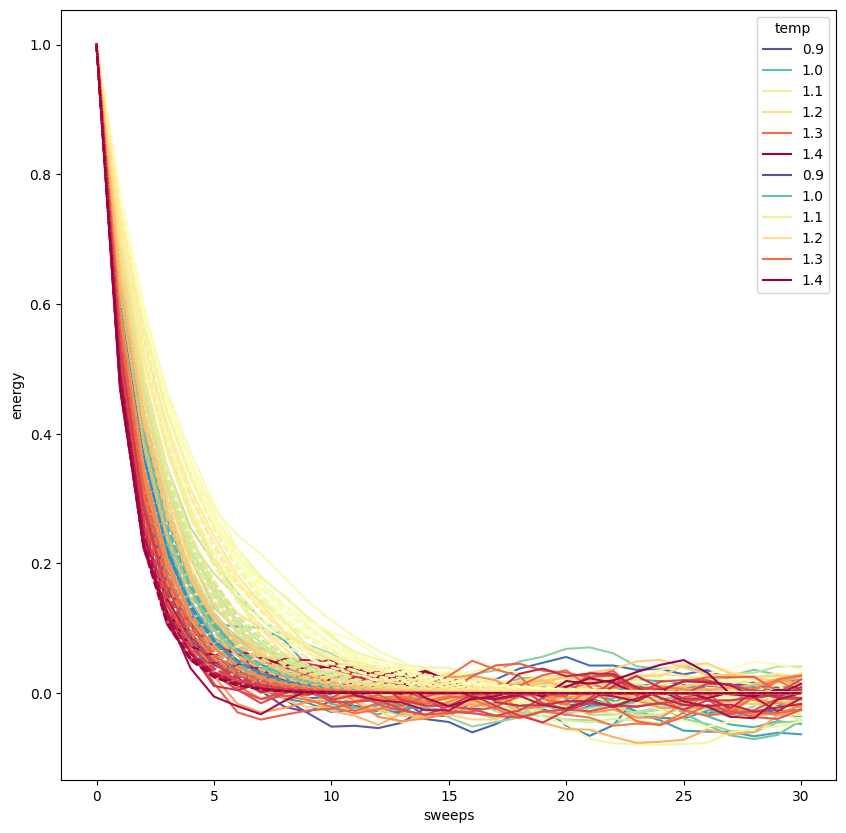

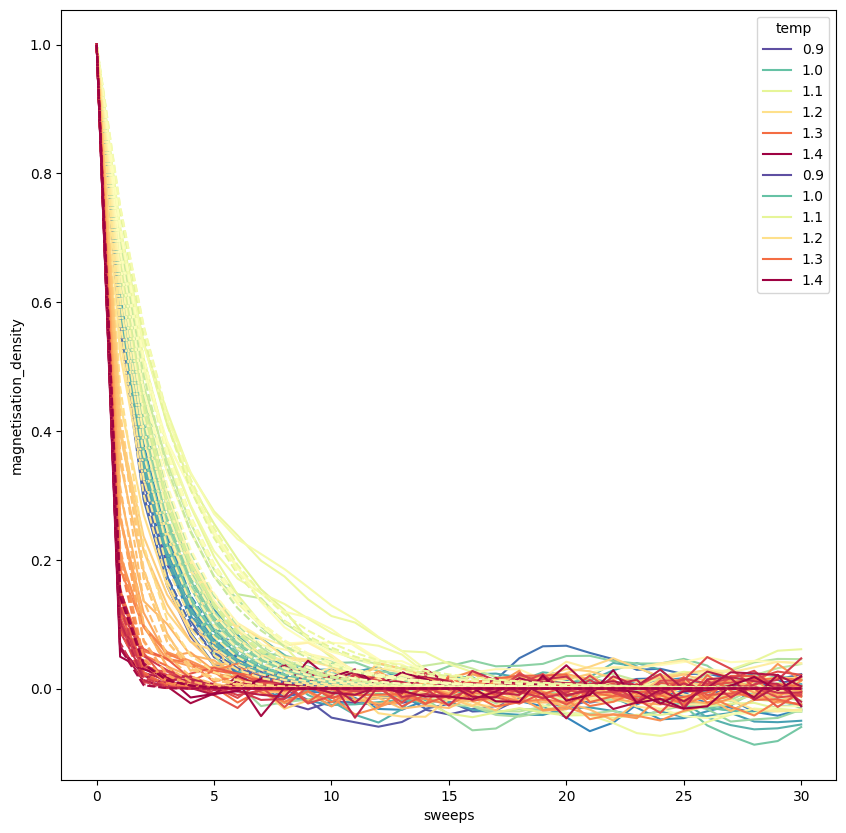

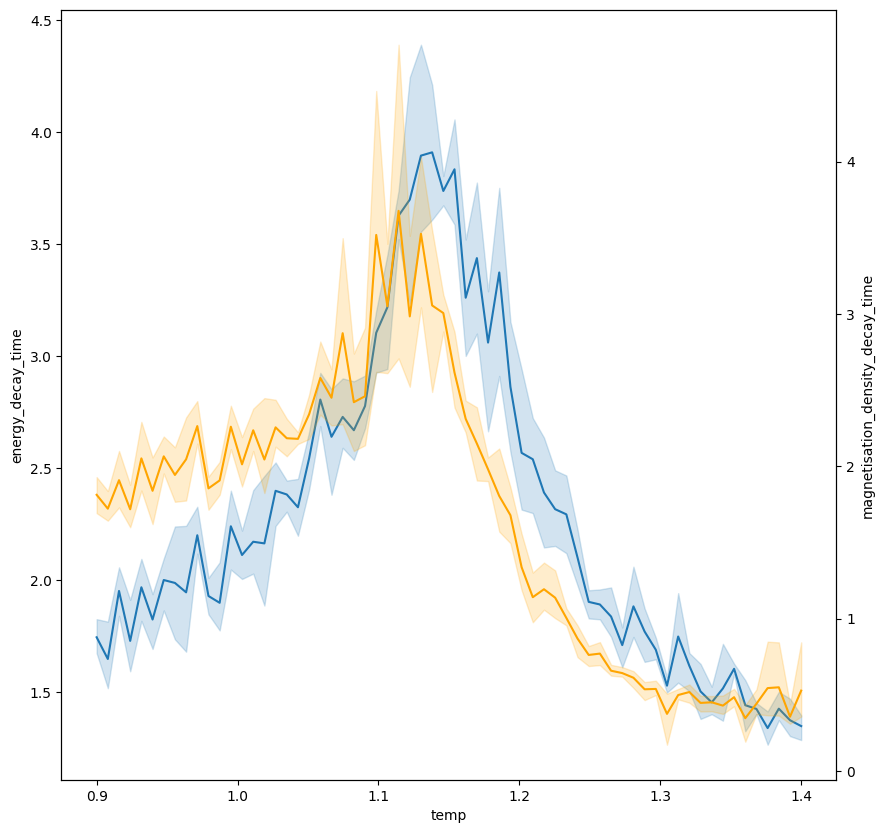

In [19]:
if c.do_autocorrelation:
    fig_autocorrelation_energy = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_energy.savefig(SAVE_PATH / "fig_autocorrelation_energy.png")

    fig_autocorrelation_mag_dens = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="magnetisation_density",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="mag_dens_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_mag_dens.savefig(SAVE_PATH / "fig_autocorrelation_mag_dens.png")

    fig_autocorrelation_decay_times, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    sns.lineplot(
        data=ac_df,
        x="temp",
        y="energy_decay_time",
        ax=ax1,
    )
    sns.lineplot(
        data=ac_df,
        x="temp",
        y="magnetisation_density_decay_time",
        ax=ax2,
        color="orange",
    )
    plt.show()
    fig_autocorrelation_decay_times.savefig(
        SAVE_PATH / "fig_autocorrelation_decay_times.png"
    )

# Measure Equilibrium

In [20]:
if c.do_measure:

    @transforms(in_axes=(0, 0, None, None, None, None), out_axes=0)
    def measure_equilibrium(
        key: RNGKey, state: State, steps: int, num: int, sweeps: int, num_prints: int
    ) -> Measurement:
        def body_fun(carry: State, x: RNGKey):
            _rng_key = x
            measurements = carry.evolve_and_measure_multiple(
                rng_key=_rng_key, num=num, sweeps=sweeps
            )

            return carry, measurements

        keys = random.split(key=key, num=steps)
        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=body_fun, init=state, xs=keys)

        return measurements

    keys = k.shaped(states.transformation_shape)

    measurement_timer = Stopwatch.start()
    equil_measurements = measure_equilibrium(
        keys,
        states,
        c.measure_equilibrium_steps,
        c.measure_equilibrium_num,
        c.measure_equilibrium_sweeps_per_step,
        10,
    )
    equil_measurements.block_until_ready()

    measurement_time = measurement_timer.time()
    to_save["measurement_time"] = measurement_time
    print(f"Ran measurement program in: {measurement_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "equil_measurements.eqx", equil_measurements)

In [21]:
if c.do_measure:
    _eq_df = equil_measurements.to_df()
    eq_df = _eq_df.explode(_eq_df.columns.tolist()).infer_objects()
    eq_df

In [22]:
if c.do_measure:
    # Create two dataframes of different 'shapes'
    # meas_df: holds data that is defined on every state
    # sample_df: holds data that is summarised across particular systems (those with same state_id)
    # temp_df: holds data that is summarised across all systems of a particular temperature
    def find_bootstrap_std_err(data):
        bootstraps = bootstrap(jnp.asarray(data), jnp.var, num_samples=32, key=k.new)
        std = jnp.std(bootstraps)
        return std.item()

    meas_df = eq_df.copy()
    meas_df["natural_temperature"] = beta_to_temp(meas_df["beta"], human=True)
    meas_df["temperature"] = beta_to_temp(meas_df["beta"], human=False)
    meas_df["abs_magnetisation_density"] = np.abs(meas_df["magnetisation_density"])

    temp_df = pd.DataFrame()

    # Energy - Summarised
    temp_group = meas_df.groupby(["natural_temperature", "temperature", "beta"])
    temp_df["energies_mean"] = temp_group["energy"].mean()
    temp_df["energies_var"] = temp_group["energy"].var()
    temp_df["energies_var_sd"] = temp_group["energy"].apply(find_bootstrap_std_err)
    temp_df["energies_var_var"] = temp_df["energies_var_sd"] ** 2

    # Magnetisation Density - Summarised
    temp_df["mag_dens_mean"] = temp_group["magnetisation_density"].mean()
    temp_df["mag_dens_var"] = temp_group["magnetisation_density"].var()
    temp_df["mag_dens_var_sd"] = temp_group["magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_var_var"] = temp_df["mag_dens_var_sd"] ** 2

    temp_df["mag_dens_abs_mean"] = temp_group["abs_magnetisation_density"].mean()
    temp_df["mag_dens_abs_var"] = temp_group["abs_magnetisation_density"].var()
    temp_df["mag_dens_abs_var_sd"] = temp_group["abs_magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_abs_var_var"] = temp_df["mag_dens_abs_var_sd"] ** 2

    # index
    temp_df = temp_df.reset_index()

    # Heat Capacity
    temp_df["heat_cap_fluctuation"] = temp_df["energies_var"] / (
        constants.Boltzmann * np.square(temp_df["temperature"].astype(np.float128))
    ).astype(np.float64)
    temp_df["heat_cap_gradient"] = np.gradient(
        temp_df["energies_mean"], temp_df["temperature"].astype(np.float128)
    ).astype(np.float64)

    # Magnetic Susceptibility
    if not c.interaction_external_field:
        temp_df["mag_sus_fluctuation"] = (
            states.size
            * constants.Boltzmann
            * temp_df["beta"]
            * temp_df["mag_dens_abs_var"]
        )
        temp_df["mag_sus_gradient"] = states.size * np.abs(
            np.gradient(
                temp_df["mag_dens_abs_mean"], temp_df["temperature"].astype(np.float128)
            ).astype(np.float64)
        )

    # Binder cumulant
    sample_df = pd.DataFrame()

    meas_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
    meas_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
    meas_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

    sample_group = meas_df.groupby("state_id")

    sample_df["mag_1_mean"] = meas_df.groupby("state_id")["mag_1"].mean()
    sample_df["mag_2_mean"] = meas_df.groupby("state_id")["mag_2"].mean()
    sample_df["mag_4_mean"] = meas_df.groupby("state_id")["mag_4"].mean()

    sample_df["binder_2"] = 1 - sample_df["mag_2_mean"] / np.square(
        sample_df["mag_1_mean"]
    )
    sample_df["binder_4"] = 1.0 / 3.0 - sample_df["mag_4_mean"] / (
        3.0 * np.square(sample_df["mag_2_mean"])
    )

    sample_df["natural_temperature"] = sample_group["natural_temperature"].first()
    sample_df["temperature"] = sample_group["temperature"].first()
    sample_df["beta"] = sample_group["beta"].first()

    meas_df.reset_index().to_feather(SAVE_PATH / "meas_df.feather")
    temp_df.reset_index().to_feather(SAVE_PATH / "temp_df.feather")
    sample_df.reset_index().to_feather(SAVE_PATH / "sample_df.feather")

In [23]:
if c.do_measure:
    fig_measure_energy_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="energy",
        kind="line",
    )
    fig_measure_energy_temp.savefig(SAVE_PATH / "fig_measure_energy_temp.png")

    fig_measure_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="magnetisation_density",
        # kind="line",
    )
    fig_measure_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_mag_dens_temp.png")

    fig_measure_abs_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="abs_magnetisation_density",
        kind="line",
    )
    fig_measure_abs_mag_dens_temp.savefig(
        SAVE_PATH / "fig_measure_abs_mag_dens_temp.png"
    )

In [24]:
if c.do_measure:
    fig_measure_heat_cap_fluctuation_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_fluctuation",
        kind="line",
    )
    fig_measure_heat_cap_fluctuation_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_fluctuation_temp.png"
    )

    fig_measure_heat_cap_gradient_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_gradient",
        kind="line",
    )
    fig_measure_heat_cap_gradient_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_gradient_temp.png"
    )

    if not c.interaction_external_field:
        fig_measure_mag_sus_fluctuation_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_fluctuation",
            kind="line",
        )
        fig_measure_mag_sus_fluctuation_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_fluctuation_temp.png"
        )

        fig_measure_mag_sus_gradient_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_gradient",
            kind="line",
        )
        fig_measure_mag_sus_gradient_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_gradient_temp.png"
        )

In [25]:
if c.do_measure:
    fig_measure_binder_2 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_2",
        kind="line",
    )
    fig_measure_binder_2.savefig(SAVE_PATH / "fig_measure_binder_2.png")

    fig_measure_binder_4 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_4",
        kind="line",
    )
    fig_measure_binder_4.savefig(SAVE_PATH / "fig_measure_binder_4.png")

In [26]:
with open(SAVE_PATH / "saved_variables.json", "w") as f:
    json.dump(
        to_save, f, indent=4, sort_keys=True, ensure_ascii=False, cls=NumpyEncoder
    )